In [1]:
import numpy as np
np.random.seed(42)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pingouin import cronbach_alpha, normality, homoscedasticity, ttest, anova, pairwise_tukey, pairwise_gameshowell, corr

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_error, silhouette_score
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from sklearn.cluster import KMeans

from catboost import Pool, CatBoostRegressor, MetricVisualizer

import warnings
warnings.filterwarnings("ignore")

# Data preprocessing

In [2]:
data = pd.read_csv('db.csv', parse_dates=[0])
data = data.drop(columns=[data.columns[-2], data.columns[-1]])
data = data.dropna()

for i in data.index:
    if not data['Укажите, сколько Вам полных лет (только число).'][i].isnumeric():
        data.drop(index=[i], inplace=True)
    elif not 15 < int(data['Укажите, сколько Вам полных лет (только число).'][i]) < 35:
        data.drop(index=[i], inplace=True)

with open("variables.txt") as infile:
    data.columns = [var.strip() for var in infile.readlines()]

n_respondents = data.shape[0]
data.index = range(n_respondents)
print('Number of respondents:', n_respondents)
data.sample()

Number of respondents: 686


,time,control,volunteer_exp,donation_exp,known_org,media_freq,police_night,criminalized,vote_change,med_ndnt,...,nodocs_exp,docs_difficulty,ask_exp_1,ask_exp_2,dresscode_exp,gndr,major,housing,age,fin_sit
286,2024-04-03 00:26:08,Да,Да,Да,Знаю две-три,Иногда,2,1 - абсолютно не согласен,2,2,...,Да,Нет,Нет,Нет,Нет,Мужской,"Техническое (математика, инженерия, архитектур...",Квартира в Вашей или семейной собственности,19,Денег хватает только на приобретение продуктов...


In [3]:
with open('labels.txt', encoding='utf8') as lbl:
    lab = []
    for line in lbl.readlines():
        line = line.strip()
        brace_ind = line.find('[')
        if brace_ind == -1:
            lab.append(line)
        else:
            lab.append(line[brace_ind + 1:-1])

labels = pd.DataFrame([lab], columns=data.columns)
labels

,time,control,volunteer_exp,donation_exp,known_org,media_freq,police_night,criminalized,vote_change,med_ndnt,...,nodocs_exp,docs_difficulty,ask_exp_1,ask_exp_2,dresscode_exp,gndr,major,housing,age,fin_sit
0,Отметка времени,Являетесь ли Вы студентом бакалавриата или спе...,У Вас или Ваших знакомых был опыт волонтёрства...,Вы совершали какие-либо материальные пожертвов...,"Примерно укажите, сколько организаций, помогаю...","Оцените, как часто в Ваше инфополе попадают ме...",Сотрудники полиции должны помогать бездомным л...,Бродяжничество должно быть криминализировано в...,"Необходимо внести поправки в законодательство,...",Сотрудники скорой помощи не обязаны помогать б...,...,У Вас возникали трудности с передвижением или ...,У Вас возникали серьёзные трудности с оформлен...,Вам приходилось обращаться за материальной пом...,Вы обращались за нематериальной помощью к незн...,Вас не пропускали куда-либо из-за неподобающег...,Укажите Ваш пол.,Укажите направление Вашего образования.,Ваше основное жилье в настоящий момент – это …,"Укажите, сколько Вам полных лет (только число).",Оцените материальное положение Вашей семьи.


In [4]:
awarness = data[['volunteer_exp', 
                 'donation_exp', 
                 'known_org', 
                 'media_freq'
                 ]]

policy = data[['police_night', 'criminalized', 'vote_change', 'med_ndnt',
               'ompudsperson', 'hostile_archt', 'putin', 'more_money_ndnt', 
               'sizo', 'president_cntrl', 'free_med'
               ]]

contact_exp = data[['purchase_exp', 'moneygive_exp', 'dialog_exp', 
                    'ciggive_exp', 'inquire_exp', 'call03_exp'
                    ]]

public_att = data[['dnt_bother', 'isolation_ndnt', 'dist_status', 
               'culture_access', 'services_in_center', 'wake_up', 
               'spoil_leisure', 'station_access', 'no_service_near'
               ]]

priority_gov_help = data['priority_ghelp']

empathy = data['sympathy']

disgust = data[['sneeze', 'bottle_share', 'pen_chew', 
               'no_ill', 'handshake_wash', 'ill_exposure', 
               'sec_hand', 'dirty_money', 'ill_anx'
                ]]

hml_exp = data[['overnight_exp', 'nodocs_exp', 
                'docs_difficulty', 'ask_exp_1', 
                'ask_exp_2', 'dresscode_exp'
                ]]

soc_dem = data[['gndr', 
                'major', 
                'housing', 
                'age', 
                'fin_sit'
                ]]

##### Imputing

In [5]:
for col in contact_exp.columns:
    for val in contact_exp[col].value_counts():
        if val < 10:
            print(f'contact_exp: {col}, amount: {val}')
for col in hml_exp.columns:
    for val in hml_exp[col].value_counts():
        if val < 10:
            print(f'column in hml_exp: {col}, amount: {val}')  

for col in awarness.columns:
    for val in awarness[col].value_counts():
        if val < 10:
            print(f'column in awarness: {col}, amount: {val}')

for col in soc_dem.drop(columns=['age']).columns:
    for val in soc_dem[col].value_counts():
        if val < 10:
            print(f'column in soc_dem: {col}, amount: {val}')

column in awarness: media_freq, amount: 4
column in soc_dem: major, amount: 2
column in soc_dem: major, amount: 2
column in soc_dem: major, amount: 2
column in soc_dem: major, amount: 1
column in soc_dem: major, amount: 1
column in soc_dem: major, amount: 1
column in soc_dem: major, amount: 1
column in soc_dem: major, amount: 1
column in soc_dem: major, amount: 1
column in soc_dem: major, amount: 1
column in soc_dem: major, amount: 1
column in soc_dem: major, amount: 1
column in soc_dem: major, amount: 1
column in soc_dem: major, amount: 1
column in soc_dem: major, amount: 1
column in soc_dem: major, amount: 1
column in soc_dem: major, amount: 1
column in soc_dem: major, amount: 1
column in soc_dem: major, amount: 1
column in soc_dem: major, amount: 1
column in soc_dem: housing, amount: 2
column in soc_dem: housing, amount: 1
column in soc_dem: housing, amount: 1
column in soc_dem: housing, amount: 1
column in soc_dem: housing, amount: 1


In [6]:
awarness['media_freq'] = awarness['media_freq'].apply(lambda x: 'Регулярно' if x == 'Часто' else x)

print('After imputing:')
print(awarness.media_freq.value_counts())

After imputing:
media_freq
Редко        318
Никогда      208
Иногда       121
Регулярно     39
Name: count, dtype: int64


In [7]:
def housing_impute(string):
    if string.startswith('Квартира'):
        return 'Квартира в собственности'
    elif string.startswith('Комната(ы)') or string.startswith('живу в студенческой общаге'):
        return 'Комната в общежитии'
    elif string.startswith('Дом,'):
        return 'Дом в собственности'
    elif string.startswith('Аренд') or string.startswith('квартира друзей') or string.startswith('Муниципальная'):
        return 'Арендуемое жильё'
    else:
        return 'undefined'
    

soc_dem['housing'] = soc_dem['housing'].apply(housing_impute)

print('After imputing:')
print(soc_dem.housing.value_counts())

After imputing:
housing
Квартира в собственности    358
Комната в общежитии         195
Арендуемое жильё            107
Дом в собственности          26
Name: count, dtype: int64


In [8]:
def major_parser(string):
    spl = string.split(' (')
    if len(spl) != 1 and len(spl[0].split()) == 1:
        return spl[0].strip()
    string = string.lower()
    if string in ['творческое', 'художественное', 'философия', 'искусство'] or 'дизайн' in string or 'кино' in string or 'гуманитарное' in string:
        return 'Гуманитарное'
    elif string in ['биомедицинская инженерия', 'бизнес-информатика', ] or 'техническое' in string:
        return 'Техническое'
    else:
        return 'Социально-экономическое'
    
soc_dem['major'] = soc_dem['major'].apply(major_parser)
print('After imputing:')
print(soc_dem.housing.value_counts())

After imputing:
housing
Квартира в собственности    358
Комната в общежитии         195
Арендуемое жильё            107
Дом в собственности          26
Name: count, dtype: int64


##### Encoding

In [9]:
encoding_awarness = {'volunteer_exp': {'Да': 1,
                                       'Нет или мне об этом неизвестно': 0}}

encoding_bin = {'Да': 1,
                'Нет': 0}

encoding_policy = {'5 - абсолютно согласен': 2,
                   '4': 1,
                   '3': 0,
                   '2': -1,
                   '1 - абсолютно не согласен': -2}
encoding_policy_r = {k: -v for k, v in encoding_policy.items()}

policy_scale = (True, False, True, False, True, False, False, False, False, True, True)

public_att_scale = (True, True, False, False, True, False, False, False, False)

encoding_empathy = {'Точно да': 2,
                    'Скорее да': 1,
                    'Ни да, ни нет': 0,
                    'Затрудняюсь ответить': 0,
                    'Скорее нет': -1,
                    'Точно нет': -2}

encoding_disgust = {'7 - полностью согласен': 3,
                    "6": 2,
                    "5": 1,
                    "4": 0,
                    "3": -1,
                    "2": -2,
                    '1 - полностью не согласен': -3}
encoding_disgust_r = {k: -v for k, v in encoding_disgust.items()}

disgust_scale = (False, True, False, True, False, False, False, True, True)

In [10]:
awarness.volunteer_exp = awarness.volunteer_exp.map(encoding_awarness['volunteer_exp'])
awarness.donation_exp = awarness.donation_exp.map(encoding_bin)

for i in range(len(policy.columns)):
    if policy_scale[i]:
        policy[policy.columns[i]] = policy[policy.columns[i]].map(encoding_policy)
    else:
        policy[policy.columns[i]] = policy[policy.columns[i]].map(encoding_policy_r)

for col in contact_exp.columns:
    contact_exp[col] = contact_exp[col].map(encoding_bin)

for i in range(len(public_att.columns)):
    if public_att_scale[i]:
        public_att[public_att.columns[i]] = public_att[public_att.columns[i]].map(encoding_policy)
    else:
        public_att[public_att.columns[i]] = public_att[public_att.columns[i]].map(encoding_policy_r)

priority_gov_help = priority_gov_help.map(lambda x: -x + 10)

empathy = empathy.map(encoding_empathy)

for i in range(len(disgust.columns)):
    if disgust_scale[i]:
        disgust[disgust.columns[i]] = disgust[disgust.columns[i]].map(encoding_disgust)
    else:
        disgust[disgust.columns[i]] = disgust[disgust.columns[i]].map(encoding_disgust_r)

for col in hml_exp.columns:
    hml_exp[col] = hml_exp[col].map(encoding_bin)

soc_dem.age = soc_dem.age.astype(int)

##### Cronbach's Alpha for Indexes

In [11]:
res = cronbach_alpha(disgust)
alpha = res[0]
print("Значение Альфы Кронбаха для disgust:", alpha)
if alpha >= 0.65:
    print("Можем объединить переменные в индекс")
else:
    print("Нет оснований суммировать переменные в индекс")

Значение Альфы Кронбаха для disgust: 0.70396210621782
Можем объединить переменные в индекс


In [12]:
res = cronbach_alpha(policy)
alpha = res[0]
print("Значение Альфы Кронбаха для policy:", alpha)
if alpha >= 0.65:
    print("Можем объединить переменные в индекс")
else:
    print("Нет оснований суммировать переменные в индекс")

Значение Альфы Кронбаха для policy: 0.7799197842567633
Можем объединить переменные в индекс


In [13]:
res = cronbach_alpha(public_att)
alpha = res[0]
print("Значение Альфы Кронбаха для public_att:", alpha)
if alpha >= 0.65:
    print("Можем объединить переменные в индекс")
else:
    print("Нет оснований суммировать переменные в индекс")

Значение Альфы Кронбаха для public_att: 0.766625646771342
Можем объединить переменные в индекс


In [14]:
res = cronbach_alpha(pd.concat([policy, public_att], axis=1))
alpha = res[0]
print("Значение Альфы Кронбаха для attitude:", alpha)
if alpha >= 0.65:
    print("Можем объединить переменные в индекс")
else:
    print("Нет оснований суммировать переменные в индекс")

Значение Альфы Кронбаха для attitude: 0.8644609843389998
Можем объединить переменные в индекс


##### Forming indexes, normalization, concatenation, reshaping and splitting

In [15]:
disgust_ind = disgust.apply(np.sum, axis=1)
policy_ind = policy.apply(np.sum, axis=1)
public_att_ind = public_att.apply(np.sum, axis=1)

def min_max_normalizer(variable):
    return (variable - variable.min()) / (variable.max() - variable.min())

public_att_ind = min_max_normalizer(public_att_ind)
policy_ind = min_max_normalizer(policy_ind)

indexes = pd.concat([policy_ind, public_att_ind], axis=1)
indexes.columns = ['policy_ind', "public_att_ind"]
indexes['attitude'] = indexes.apply(np.sum, axis=1)

In [16]:
X = pd.concat([contact_exp, hml_exp, awarness, priority_gov_help, empathy, soc_dem], axis=1)
X['disgust_ind'] = disgust_ind
y = indexes
data = pd.concat([X, y], axis=1)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.1)

# EDA

##### Typical respondent

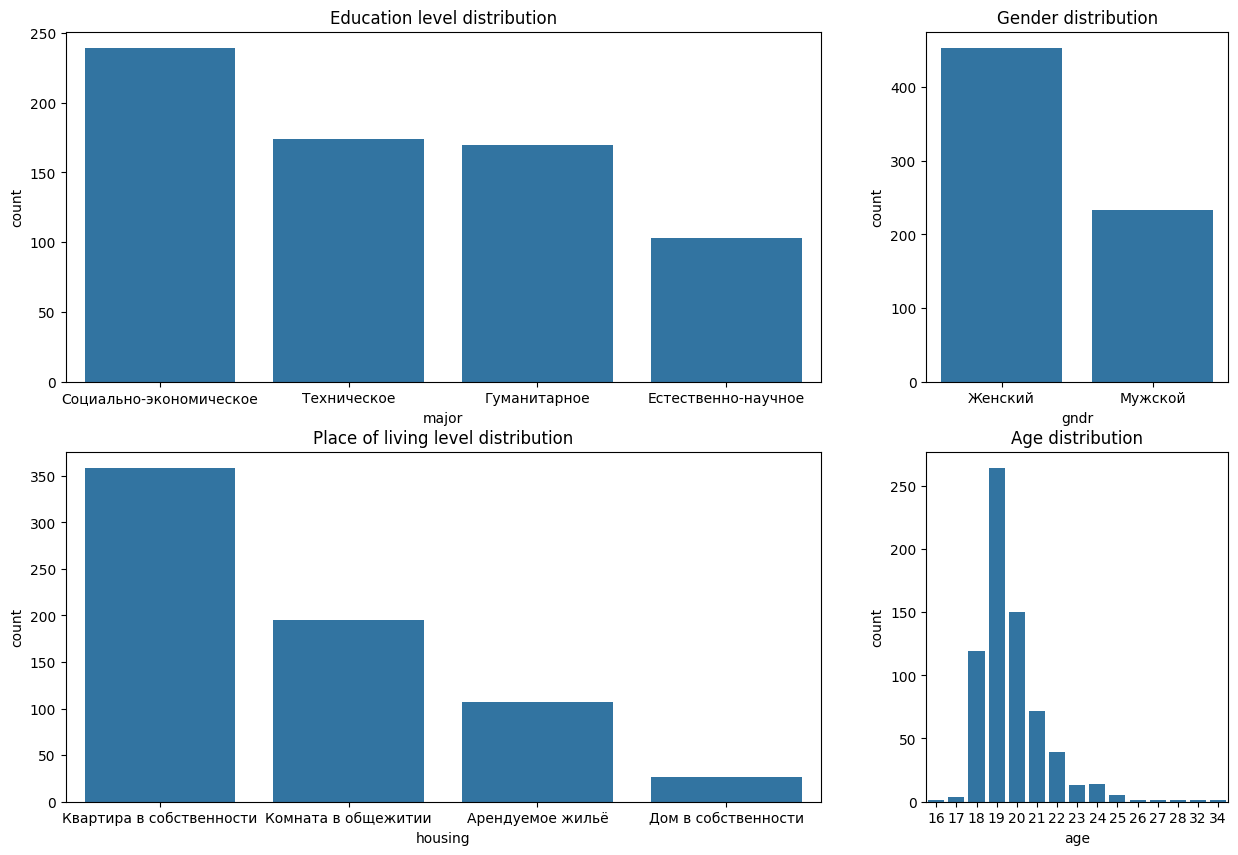

In [18]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, width_ratios=[2.5, 1], figsize=(15, 10))

sns.barplot(data['gndr'].value_counts(), ax=ax2)
ax2.set_title('Gender distribution')

sns.barplot(data['major'].value_counts(), ax=ax1)
ax1.set_title('Education level distribution')

sns.barplot(data['age'].value_counts(), ax=ax4)
ax4.set_title('Age distribution')

sns.barplot(data['housing'].value_counts(), ax=ax3)
ax3.set_title('Place of living level distribution')

plt.show()

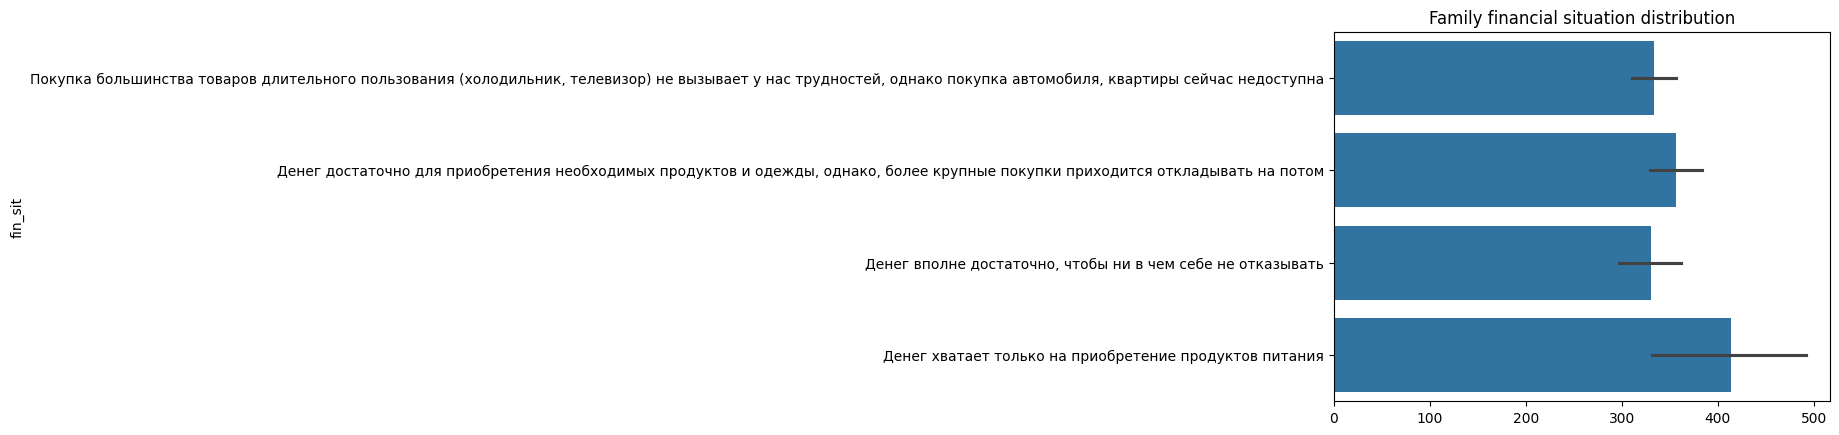

In [19]:
sns.barplot(data['fin_sit'])
plt.title('Family financial situation distribution')
plt.show()

Как можем наблюдать, типичный респондент - студентка бакалавриата московского вуза, которая проживает в собственной квартире (или в квартире семьи), обучается на социально-экономической специальности и её семьи покупка большинства товаров длительного пользования (холодильник, телевизор) не вызывает у нас трудностей, однако покупка автомобиля, квартиры сейчас недоступна.

##### Target variables descriptives

Тест Шапиро-Уилка на нормальность распраделения переменной test
                W          pval  normal
attitude  0.97393  1.051161e-09   False


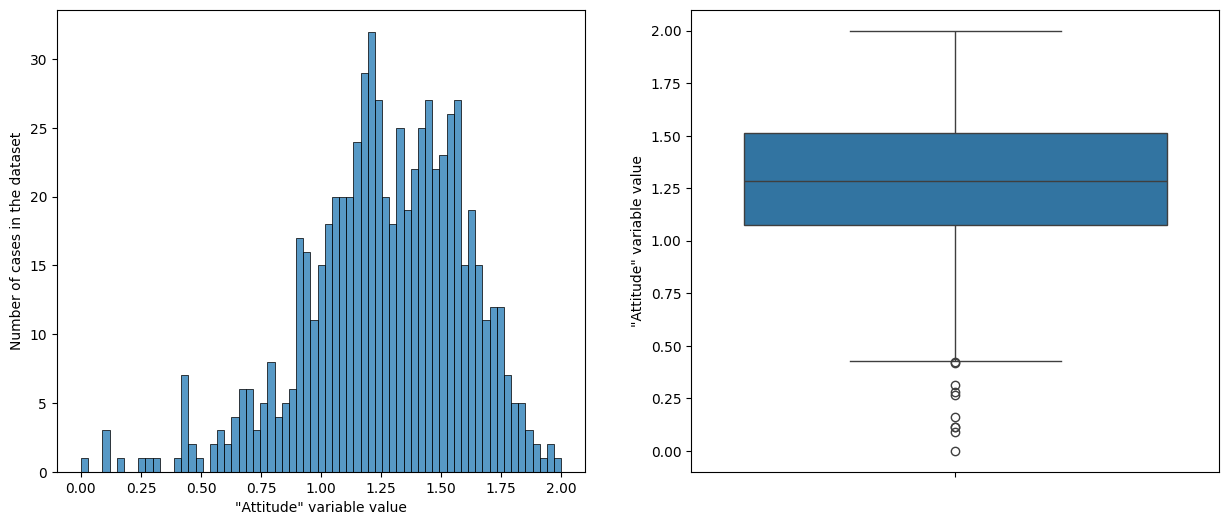

In [20]:
print('Тест Шапиро-Уилка на нормальность распраделения переменной test')
print(normality(data['attitude']))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

sns.histplot(data['attitude'], binwidth=0.03, ax=ax1)
sns.boxplot(data['attitude'], ax=ax2)
ax1.set_xlabel('"Attitude" variable value')
ax1.set_ylabel('Number of cases in the dataset')
ax2.set_ylabel('"Attitude" variable value')
plt.show()

Тест Шапиро-Уилка на нормальность распраделения переменной "policy_ind"
                   W          pval  normal
policy_ind  0.964586  8.122624e-12   False


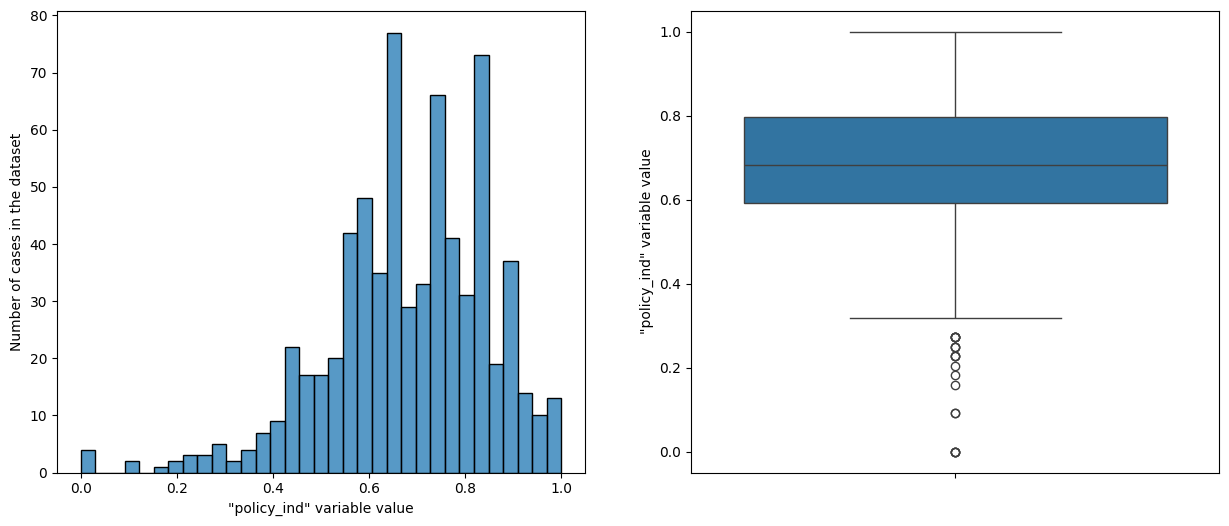

In [21]:
print('Тест Шапиро-Уилка на нормальность распраделения переменной "policy_ind"')
print(normality(data['policy_ind']))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

sns.histplot(data['policy_ind'], binwidth=0.03, ax=ax1)
sns.boxplot(data['policy_ind'], ax=ax2)

ax1.set_xlabel('"policy_ind" variable value')
ax1.set_ylabel('Number of cases in the dataset')
ax2.set_ylabel('"policy_ind" variable value')
plt.show()

Тест Шапиро-Уилка на нормальность распраделения переменной "public_att_ind"
                       W      pval  normal
public_att_ind  0.984648  0.000001   False


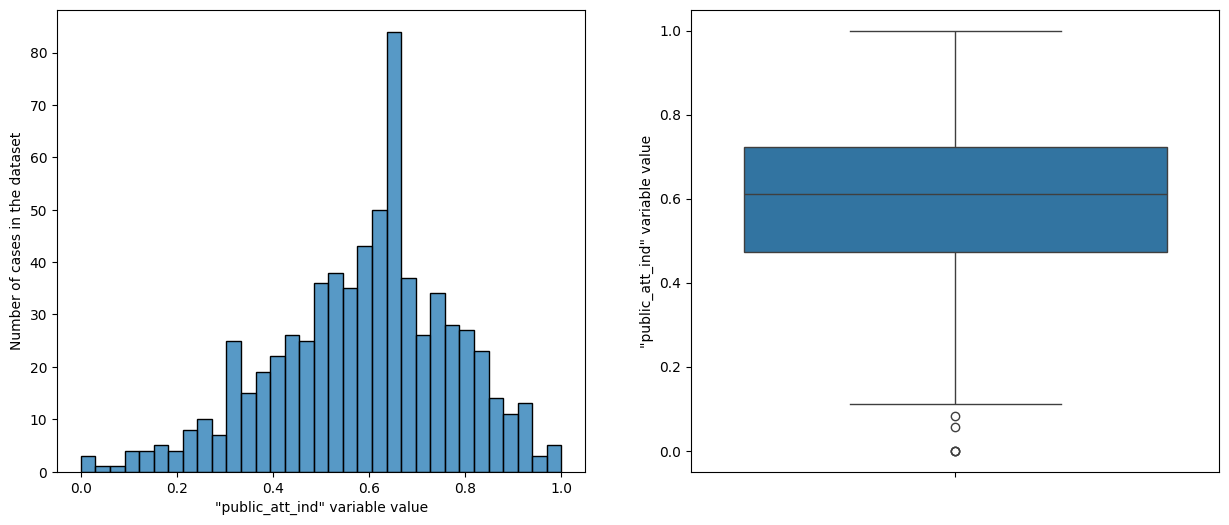

In [22]:
print('Тест Шапиро-Уилка на нормальность распраделения переменной "public_att_ind"')
print(normality(data['public_att_ind']))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

sns.histplot(data['public_att_ind'], binwidth=0.03, ax=ax1)
sns.boxplot(data['public_att_ind'], ax=ax2)
ax1.set_xlabel('"public_att_ind" variable value')
ax1.set_ylabel('Number of cases in the dataset')
ax2.set_ylabel('"public_att_ind" variable value')
plt.show()

##### Распределение disgust_ind

Тест Шапиро-Уилка на нормальность распраделения переменной "disgust_ind"
                    W      pval  normal
disgust_ind  0.995395  0.038878   False


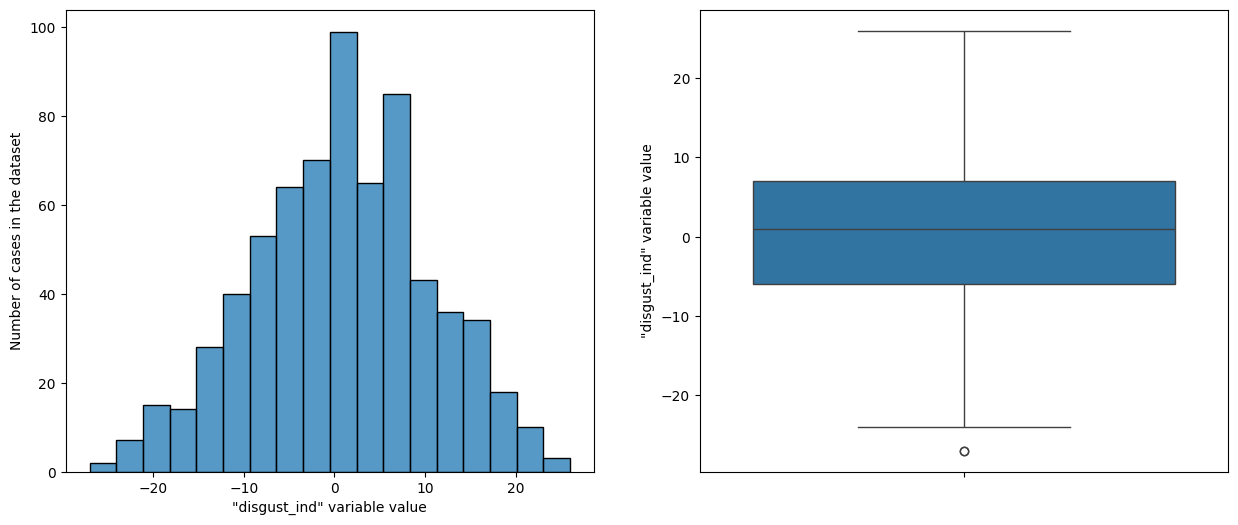

In [23]:
print('Тест Шапиро-Уилка на нормальность распраделения переменной "disgust_ind"')
print(normality(data['disgust_ind']))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

sns.histplot(data['disgust_ind'], ax=ax1)
sns.boxplot(data['disgust_ind'], ax=ax2)
ax1.set_xlabel('"disgust_ind" variable value')
ax1.set_ylabel('Number of cases in the dataset')
ax2.set_ylabel('"disgust_ind" variable value')
plt.show()

# Pairwise Tests

#### Part about soc dem

##### Hypothesis #1 : male students have higher "public_att_ind" than women

In [24]:
# equal variance test
homoscedasticity(data=data, 
                 dv="public_att_ind", 
                 group="gndr", 
                 method="levene")

,W,pval,equal_var
levene,9.826202,0.001794,False


In [25]:
res = ttest(x=data[data["gndr"] == "Мужской"]["public_att_ind"], 
            y=data[data["gndr"] == "Женский"]["public_att_ind"], 
            paired=False,
            alternative="less",
            correction=True)

display(res)
if res["p-val"].iloc[0] <= 0.05:
    print("Математическое ожидание индекса отношения к пребыванию бездомных в общественных пространствах:", "\n"
          "Мужчины:", data[data["gndr"] == "Мужской"]["public_att_ind"].mean(), "\n"
          "Женщины:", data[data["gndr"] == "Женский"]["public_att_ind"].mean())
else:
    print("Результат статистически незначим")

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-4.134065,397.987763,less,0.000022,"[-inf, -0.04]",0.354236,695.534,0.996972


Математическое ожидание индекса отношения к пребыванию бездомных в общественных пространствах: 
Мужчины: 0.5468526466380544 
Женщины: 0.6115403482953153


##### Hypothesis #2 
т-тест для независимых policy_ind и пол (у женщин выше, дисперсии разные)

In [26]:
homoscedasticity(data=data, 
                 dv="policy_ind", 
                 group="gndr", 
                 method="levene")

,W,pval,equal_var
levene,14.344626,0.000166,False


In [27]:
res = ttest(x=data[data["gndr"] == "Мужской"]["policy_ind"], 
            y=data[data["gndr"] == "Женский"]["policy_ind"], 
            paired=False,
            alternative="less",
            correction=True)

display(res)
if res["p-val"].iloc[0] <= 0.05:
    print("Математическое ожидание индекса инклюзивности представлений о корректной государственной политике по отношению к бездомным людям:", "\n"
          "Мужчины:", data[data["gndr"] == "Мужской"]["policy_ind"].mean(), "\n"
          "Женщины:", data[data["gndr"] == "Женский"]["policy_ind"].mean())
else:
    print("Результат статистически незначим")

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-5.617347,363.991025,less,1.928720e-08,"[-inf, -0.06]",0.498814,6.6e+05,0.999997


Математическое ожидание индекса инклюзивности представлений о корректной государственной политике по отношению к бездомным людям: 
Мужчины: 0.6249512290284823 
Женщины: 0.7068031306441901


##### Hypothesis 3
т-тест для независимых attitude и пол (у женщин выше, дисперсии разные)

In [28]:
homoscedasticity(data=data, 
                 dv="attitude", 
                 group="gndr", 
                 method="levene")

,W,pval,equal_var
levene,11.216709,0.000855,False


In [29]:
res = ttest(x=data[data["gndr"] == "Мужской"]["attitude"], 
      y=data[data["gndr"] == "Женский"]["attitude"], 
      paired=False,
      alternative="less",
      correction=True)

display(res)
if res["p-val"].iloc[0] <= 0.05:
    print("Математическое ожидание индекса толерантности отношения к бездомным людям:", "\n"
          "Мужчины:", data[data["gndr"] == "Мужской"]["attitude"].mean(), "\n"
          "Женщины:", data[data["gndr"] == "Женский"]["attitude"].mean())
else:
    print("Результат статистически незначим")

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-5.21756,371.159264,less,1.510913e-07,"[-inf, -0.1]",0.459631,8.583e+04,0.999974


Математическое ожидание индекса толерантности отношения к бездомным людям: 
Мужчины: 1.1718038756665365 
Женщины: 1.3183434789395054


##### Hypothesis 4
ANOVA policy_ind и major

In [30]:
anova(data=data, 
      dv="policy_ind", 
      between="major", 
      detailed=True)

,Source,SS,DF,MS,F,p-unc,np2
0,major,0.652311,3,0.217437,7.889441,0.000035,0.03354
1,Within,18.796277,682,0.027561,NaN,NaN,NaN


In [31]:
homoscedasticity(data=data, 
                 dv="policy_ind", 
                 group="major", 
                 method="levene")

,W,pval,equal_var
levene,1.733702,0.15873,True


In [32]:
# equal variances, so tukey-HSD
res = pairwise_tukey(data=data, 
               dv="policy_ind", 
               between="major")

res[res["p-tukey"] <= 0.05]
## различия присутствуют между гуманитарным и техническим, гуманитарным и социально-экономическим

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
1,Гуманитарное,Социально-экономическое,0.726604,0.662704,0.063900,0.016656,3.836345,0.000785,0.382367
2,Гуманитарное,Техническое,0.726604,0.646552,0.080053,0.017903,4.471480,0.000054,0.495074


##### Hypothesis 5

anova attitude и материальное положение (геймс-хоуэлл, дисперсии равны, разница только "ни в чем себе не отказывать" от всех остальных)

In [33]:
anova(data=data, 
      dv="attitude", 
      between="fin_sit", 
      detailed=True)

,Source,SS,DF,MS,F,p-unc,np2
0,fin_sit,2.260657,3,0.753552,7.282523,0.000082,0.03104
1,Within,70.569328,682,0.103474,NaN,NaN,NaN


In [34]:
homoscedasticity(data=data, 
                 dv="attitude", 
                 group="fin_sit", 
                 method="levene")

,W,pval,equal_var
levene,1.807059,0.144513,True


In [35]:
# equal variances, so tukey-HSD
res = pairwise_tukey(data=data, 
               dv="attitude", 
               between="fin_sit")

res[res["p-tukey"] <= 0.05]
# ни в чём себе не отказывать везде ниже, больше различий нет

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,"Денег вполне достаточно, чтобы ни в чем себе н...",Денег достаточно для приобретения необходимых ...,1.162114,1.315633,-0.153519,0.035261,-4.353731,0.000091,-0.454529
1,"Денег вполне достаточно, чтобы ни в чем себе н...",Денег хватает только на приобретение продуктов...,1.162114,1.375598,-0.213484,0.078748,-2.710971,0.034634,-0.577885
2,"Денег вполне достаточно, чтобы ни в чем себе н...",Покупка большинства товаров длительного пользо...,1.162114,1.276666,-0.114552,0.032874,-3.484623,0.002941,-0.345284


#### Part about вовлечённость втему

##### Hypothesis 1

 т-тест для несвязных attitude и опыт волонтерства (равные дисперсии, волонтёры лучше)

In [36]:
homoscedasticity(data=data, 
                 dv="attitude", 
                 group="volunteer_exp", 
                 method="levene")

,W,pval,equal_var
levene,0.140397,0.708003,True


In [37]:
res = ttest(x=data[data["volunteer_exp"] == 0]["attitude"], 
      y=data[data["volunteer_exp"] == 1]["attitude"], 
      paired=False,
      alternative="less",
      correction=False)

display(res)
if res["p-val"].iloc[0] <= 0.05:
    print("Математическое ожидание индекса толерантности отношения к бездомным людям:", "\n"
          "Не имевшие опыт волонтёрства или знакомых-волонтёров:", data[data["volunteer_exp"] == 0]["attitude"].mean(), "\n"
          "Имевшие такой опыт или знакомых-волонтёров:", data[data["volunteer_exp"] == 1]["attitude"].mean())
else:
    print("Результат статистически незначим")

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-3.056611,684,less,0.001163,"[-inf, -0.04]",0.271383,18.079,0.920543


Математическое ожидание индекса толерантности отношения к бездомным людям: 
Не имевшие опыт волонтёрства или знакомых-волонтёров: 1.247031122031122 
Имевшие такой опыт или знакомых-волонтёров: 1.3349867724867726


##### Hypothesis 2
т-тест для независимых attitude и пожертвования (дисперсии равны, жертвующие больше)

In [38]:
homoscedasticity(data=data, 
                 dv="attitude", 
                 group="donation_exp", 
                 method="levene")

,W,pval,equal_var
levene,1.703535,0.192265,True


In [39]:
res = ttest(x=data[data["donation_exp"] == 0]["attitude"], 
      y=data[data["donation_exp"] == 1]["attitude"], 
      paired=False,
      alternative="less",
      correction=False)

display(res)
if res["p-val"].iloc[0] <= 0.05:
    print("Математическое ожидание индекса толерантности отношения к бездомным людям:", "\n"
          "Не имевшие опыт пожертвований:", data[data["donation_exp"] == 0]["attitude"].mean(), "\n"
          "Имевшие такой опыт:", data[data["donation_exp"] == 1]["attitude"].mean())
else:
    print("Результат статистически незначим")

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-5.915331,684,less,2.616625e-09,"[-inf, -0.11]",0.475904,3.301e+06,0.99999


Математическое ожидание индекса толерантности отношения к бездомным людям: 
Не имевшие опыт пожертвований: 1.216684584201214 
Имевшие такой опыт: 1.3681495809155384


##### Hypothesis 3
anova медиа и attitude (дисперсии не равны, геймс-хоуэлл) результаты - различия у (никогда – редко, никогда – иногда, никогда – регулярно, регулярно - редко)

In [40]:
anova(data=data, 
      dv="attitude", 
      between="media_freq", 
      detailed=True)

,Source,SS,DF,MS,F,p-unc,np2
0,media_freq,4.379370,3,1.459790,14.544454,3.422611e-09,0.060131
1,Within,68.450615,682,0.100367,NaN,NaN,NaN


In [41]:
homoscedasticity(data=data, 
                 dv="attitude", 
                 group="media_freq", 
                 method="levene")

,W,pval,equal_var
levene,3.599782,0.013325,False


In [42]:
# unequal variaces, so Games-Howell
res = pairwise_gameshowell(data=data,
                     dv="attitude",
                     between="media_freq")

res[res["pval"] <= 0.05]

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,Иногда,Никогда,1.352179,1.162369,0.189810,0.034741,5.463507,304.115638,5.810753e-07,0.580720
3,Никогда,Регулярно,1.162369,1.436092,-0.273723,0.064821,-4.222780,51.576350,5.544784e-04,-0.762771
4,Никогда,Редко,1.162369,1.285679,-0.123310,0.029760,-4.143503,389.361185,2.447760e-04,-0.382259


##### Hypothesis 4

anova число знакомых организаций attitude (дисперсии равны, Шеффе, не знаю ни одной отличается от всех остальных)

In [43]:
anova(data=data, 
      dv="attitude", 
      between="known_org", 
      detailed=True)

,Source,SS,DF,MS,F,p-unc,np2
0,known_org,3.756269,3,1.252090,12.36252,6.992894e-08,0.051576
1,Within,69.073716,682,0.101281,NaN,NaN,NaN


In [44]:
homoscedasticity(data=data, 
                 dv="attitude", 
                 group="known_org", 
                 method="levene")

,W,pval,equal_var
levene,2.272428,0.078957,True


In [45]:
res = pairwise_tukey(data=data,
               dv="attitude",
               between="known_org")

res[res['p-tukey'] <= 0.05]

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
2,"Знаю более, чем 3",Не знаю ни одной,1.459711,1.179985,0.279726,0.070673,3.958002,0.000484,0.806621
4,Знаю две-три,Не знаю ни одной,1.328779,1.179985,0.148793,0.031818,4.676349,0.000021,0.466038
5,Знаю одну,Не знаю ни одной,1.305451,1.179985,0.125466,0.028453,4.409614,0.000071,0.388329


#### Part about similar experience

##### Hypothesis 1
 т-тест для независимых attitude и проблемы с ночлегом (дисперсии равны, у опытных больше)

In [46]:
homoscedasticity(data=data, 
                 dv="attitude", 
                 group="overnight_exp", 
                 method="levene")

,W,pval,equal_var
levene,0.666915,0.414414,True


In [47]:
res = ttest(x=data[data["overnight_exp"] == 0]["attitude"], 
      y=data[data["overnight_exp"] == 1]["attitude"], 
      paired=False,
      alternative="less",
      correction=False)

display(res)
if res["p-val"].iloc[0] <= 0.05:
    print("Математическое ожидание индекса толерантности отношения к бездомным людям:", "\n"
          "Не имевшие опыт ночлега в общественных пространствах:", data[data["overnight_exp"] == 0]["attitude"].mean(), "\n"
          "Имевшие такой опыт:", data[data["overnight_exp"] == 1]["attitude"].mean())
else:
    print("Результат статистически незначим")

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-2.393908,684,less,0.008469,"[-inf, -0.02]",0.219055,3.25,0.772373


Математическое ожидание индекса толерантности отношения к бездомным людям: 
Не имевшие опыт ночлега в общественных пространствах: 1.252591706539075 
Имевшие такой опыт: 1.323773448773449


##### Hypothesis 2
оформление документов (дисперсии равны, результат незначим)

In [48]:
homoscedasticity(data=data, 
                 dv="attitude", 
                 group="docs_difficulty", 
                 method="levene")

,W,pval,equal_var
levene,0.07456,0.784893,True


In [49]:
res = ttest(x=data[data["docs_difficulty"] == 0]["attitude"], 
      y=data[data["docs_difficulty"] == 1]["attitude"], 
      paired=False,
      alternative="less",
      correction=False)

display(res)
if res["p-val"].iloc[0] <= 0.05:
    print("Математическое ожидание индекса толерантности отношения к бездомным людям:", "\n"
          "Не имевшие опыт трудностей с оформлением документов:", data[data["docs_difficulty"] == 0]["attitude"].mean(), "\n"
          "Имевшие такой опыт:", data[data["docs_difficulty"] == 1]["attitude"].mean())
else:
    print("Результат статистически незначим")

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.131571,684,less,0.552319,"[-inf, 0.07]",0.015567,0.262,0.037842


Результат статистически незначим


##### Hypothesis 3
мат помощь то же самое

In [50]:
homoscedasticity(data=data, 
                 dv="attitude", 
                 group="ask_exp_1", 
                 method="levene")

,W,pval,equal_var
levene,0.687845,0.407188,True


In [51]:
res = ttest(x=data[data["ask_exp_1"] == 0]["attitude"], 
      y=data[data["ask_exp_1"] == 1]["attitude"], 
      paired=False,
      alternative="less",
      correction=False)

display(res)
if res["p-val"].iloc[0] <= 0.05:
    print("Математическое ожидание индекса толерантности отношения к бездомным людям:", "\n"
          "Не имевшие опыт обращения за материальной помощью:", data[data["ask_exp_1"] == 0]["attitude"].mean(), "\n"
          "Имевшие такой опыт:", data[data["ask_exp_1"] == 1]["attitude"].mean())
else:
    print("Результат статистически незначим")

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.46523,684,less,0.679042,"[-inf, 0.08]",0.054467,0.286,0.017445


Результат статистически незначим


##### Hypothesis 4
немат помощь -||-

In [52]:
homoscedasticity(data=data, 
                 dv="attitude", 
                 group="ask_exp_2", 
                 method="levene")

,W,pval,equal_var
levene,0.738767,0.390357,True


In [53]:
res = ttest(x=data[data["ask_exp_2"] == 0]["attitude"], 
      y=data[data["ask_exp_2"] == 1]["attitude"], 
      paired=False,
      alternative="less",
      correction=False)

display(res)
if res["p-val"].iloc[0] <= 0.05:
    print("Математическое ожидание индекса толерантности отношения к бездомным людям:", "\n"
          "Не имевшие опыт обращения за нематериальной помощью:", data[data["ask_exp_2"] == 0]["attitude"].mean(), "\n"
          "Имевшие такой опыт:", data[data["ask_exp_2"] == 1]["attitude"].mean())
else:
    print("Результат статистически незначим")

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-0.371237,684,less,0.355288,"[-inf, 0.03]",0.028348,0.182,0.101335


Результат статистически незначим


##### Hypothesis 5
нет докуметов дисперсии равны, "да" больше

In [54]:
homoscedasticity(data=data, 
                 dv="attitude", 
                 group="nodocs_exp", 
                 method="levene")

,W,pval,equal_var
levene,0.877715,0.349159,True


In [55]:
res = ttest(x=data[data["nodocs_exp"] == 0]["attitude"], 
      y=data[data["nodocs_exp"] == 1]["attitude"], 
      paired=False,
      alternative="less",
      correction=False)

display(res)
if res["p-val"].iloc[0] <= 0.05:
    print("Математическое ожидание индекса толерантности отношения к бездомным людям:", "\n"
          "Не имевшие опыт ограничения возможностей из-за отсутствия документов:", data[data["nodocs_exp"] == 0]["attitude"].mean(), "\n"
          "Имевшие такой опыт:", data[data["nodocs_exp"] == 1]["attitude"].mean())
else:
    print("Результат статистически незначим")

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-2.388522,684,less,0.008593,"[-inf, -0.03]",0.25951,3.675,0.770746


Математическое ожидание индекса толерантности отношения к бездомным людям: 
Не имевшие опыт ограничения возможностей из-за отсутствия документов: 1.2564013215631613 
Имевшие такой опыт: 1.3407305377002348


##### Hypothesis 6
дресс-код дисперсии равны, результат незначим

In [56]:
homoscedasticity(data=data, 
                 dv="attitude", 
                 group="dresscode_exp", 
                 method="levene")

,W,pval,equal_var
levene,3.110347,0.078243,True


In [57]:
res = ttest(x=data[data["dresscode_exp"] == 0]["attitude"], 
      y=data[data["dresscode_exp"] == 1]["attitude"], 
      paired=False,
      alternative="less",
      correction=False)

display(res)
if res["p-val"].iloc[0] <= 0.05:
    print("Математическое ожидание индекса толерантности отношения к бездомным людям:", "\n"
          "Не имевшие опыт ограничения возможностей из-за отсутствия документов:", data[data["dresscode_exp"] == 0]["attitude"].mean(), "\n"
          "Имевшие такой опыт:", data[data["dresscode_exp"] == 1]["attitude"].mean())
else:
    print("Результат статистически незначим")

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-0.888135,684,less,0.18739,"[-inf, 0.03]",0.108665,0.39,0.224346


Результат статистически незначим


#### Part about experience on the streets

##### Hypothesis 16
ттест, если покупал - выше (purchase_exp)

In [58]:
homoscedasticity(data=data, 
                 dv="attitude", 
                 group="purchase_exp", 
                 method="levene")

,W,pval,equal_var
levene,2.166311,0.141524,True


In [59]:
res = ttest(x=data[data["purchase_exp"] == 0]["attitude"], 
      y=data[data["purchase_exp"] == 1]["attitude"], 
      paired=False,
      alternative="less",
      correction=False)

display(res)
if res["p-val"].iloc[0] <= 0.05:
    print("Математическое ожидание индекса толерантности отношения к бездомным людям:", "\n"
          "Не имевшие опыт покупки бездомному продуктов и пр.:", data[data["purchase_exp"] == 0]["attitude"].mean(), "\n"
          "Имевшие такой опыт:", data[data["purchase_exp"] == 1]["attitude"].mean())
else:
    print("Результат статистически незначим")

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-3.480983,684,less,0.000266,"[-inf, -0.05]",0.274157,62.904,0.966575


Математическое ожидание индекса толерантности отношения к бездомным людям: 
Не имевшие опыт покупки бездомному продуктов и пр.: 1.2350909564024317 
Имевшие такой опыт: 1.3237685737685738


##### Hypothesis 17
moneygive_exp если давал выше

In [60]:
homoscedasticity(data=data, 
                 dv="attitude", 
                 group="moneygive_exp", 
                 method="levene")

,W,pval,equal_var
levene,2.13217,0.144696,True


In [61]:
res = ttest(x=data[data["moneygive_exp"] == 0]["attitude"], 
      y=data[data["moneygive_exp"] == 1]["attitude"], 
      paired=False,
      alternative="less",
      correction=False)

display(res)
if res["p-val"].iloc[0] <= 0.05:
    print("Математическое ожидание индекса толерантности отношения к бездомным людям:", "\n"
          "Не имевшие опыт передачи бездомному денег:", data[data["moneygive_exp"] == 0]["attitude"].mean(), "\n"
          "Имевшие такой опыт:", data[data["moneygive_exp"] == 1]["attitude"].mean())
else:
    print("Результат статистически незначим")

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-4.29116,684,less,0.00001,"[-inf, -0.07]",0.343529,1303.498,0.99588


Математическое ожидание индекса толерантности отношения к бездомным людям: 
Не имевшие опыт передачи бездомному денег: 1.1966540404040407 
Имевшие такой опыт: 1.3072711419123977


##### Hypothesis 18
dialog_exp если был опыт диалога то больше

In [62]:
homoscedasticity(data=data, 
                 dv="attitude", 
                 group="dialog_exp", 
                 method="levene")

,W,pval,equal_var
levene,3.238428,0.07237,True


In [63]:
res = ttest(x=data[data["dialog_exp"] == 0]["attitude"], 
      y=data[data["dialog_exp"] == 1]["attitude"], 
      paired=False,
      alternative="less",
      correction=False)

display(res)
if res["p-val"].iloc[0] <= 0.05:
    print("Математическое ожидание индекса толерантности отношения к бездомным людям:", "\n"
          "Не имевшие опыт продолжительного диалога с бездомным человеком:", data[data["dialog_exp"] == 0]["attitude"].mean(), "\n"
          "Имевшие такой опыт:", data[data["dialog_exp"] == 1]["attitude"].mean())
else:
    print("Результат статистически незначим")

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-2.05504,684,less,0.020127,"[-inf, -0.01]",0.166936,1.416,0.658419


Математическое ожидание индекса толерантности отношения к бездомным людям: 
Не имевшие опыт продолжительного диалога с бездомным человеком: 1.2506807202459373 
Имевшие такой опыт: 1.3049856976848127


##### Hypothesis 19 
ciggive_exp если было то больше

In [64]:
homoscedasticity(data=data, 
                 dv="attitude", 
                 group="ciggive_exp", 
                 method="levene")

,W,pval,equal_var
levene,3.673856,0.055689,True


In [65]:
res = ttest(x=data[data["ciggive_exp"] == 0]["attitude"], 
      y=data[data["ciggive_exp"] == 1]["attitude"], 
      paired=False,
      alternative="less",
      correction=False)

display(res)
if res["p-val"].iloc[0] <= 0.05:
    print("Математическое ожидание индекса толерантности отношения к бездомным людям:", "\n"
          "Не делившиеся сигаретой с бездомным человеком:", data[data["ciggive_exp"] == 0]["attitude"].mean(), "\n"
          "Имевшие такой опыт:", data[data["ciggive_exp"] == 1]["attitude"].mean())
else:
    print("Результат статистически незначим")

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-0.693727,684,less,0.244044,"[-inf, 0.03]",0.061844,0.25,0.170596


Результат статистически незначим


##### Hypothesis 20
inquire_exp если интересовался выше

In [66]:
homoscedasticity(data=data, 
                 dv="attitude", 
                 group="inquire_exp", 
                 method="levene")

,W,pval,equal_var
levene,2.974722,0.085026,True


In [67]:
res = ttest(x=data[data["inquire_exp"] == 0]["attitude"], 
      y=data[data["inquire_exp"] == 1]["attitude"], 
      paired=False,
      alternative="less",
      correction=False)

display(res)
if res["p-val"].iloc[0] <= 0.05:
    print("Математическое ожидание индекса толерантности отношения к бездомным людям:", "\n"
          "Никогда не интересовавшиеся состоянием бездомного человека при подозрении нездоровья:", data[data["inquire_exp"] == 0]["attitude"].mean(), "\n"
          "Имевшие такой опыт:", data[data["inquire_exp"] == 1]["attitude"].mean())
else:
    print("Результат статистически незначим")

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-3.854967,684,less,0.000063,"[-inf, -0.06]",0.300328,233.509,0.986318


Математическое ожидание индекса толерантности отношения к бездомным людям: 
Никогда не интересовавшиеся состоянием бездомного человека при подозрении нездоровья: 1.229705817297058 
Имевшие такой опыт: 1.3266574839302112


##### Hypothesis 21
вызывашие скорую выше (call03_exp)

In [68]:
resd = homoscedasticity(data=data, 
                 dv="attitude", 
                 group="call03_exp", 
                 method="levene")
display(resd)

,W,pval,equal_var
levene,0.958324,0.327956,True


In [69]:
res = ttest(x=data[data["call03_exp"] == 0]["attitude"], 
      y=data[data["call03_exp"] == 1]["attitude"], 
      paired=False,
      alternative="less",
      correction= not resd['equal_var'].iloc[0])

display(res)
if res["p-val"].iloc[0] <= 0.05:
    print("Математическое ожидание индекса толерантности отношения к бездомным людям:", "\n"
          "Никогда не вызывашие скорую для бездомного человека:", data[data["call03_exp"] == 0]["attitude"].mean(), "\n"
          "Имевшие такой опыт:", data[data["call03_exp"] == 1]["attitude"].mean())
else:
    print("Результат статистически незначим")

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-1.361367,684,less,0.086923,"[-inf, 0.01]",0.14493,0.572,0.387886


Результат статистически незначим


#### Part about correlations

In [70]:
for var in ['disgust_ind', 'priority_ghelp', 'sympathy']:
    res = corr(data['attitude'], data[var])
    if res['p-val'].iloc[0] <= 0.05:
        print(f'Коэффициент корреляции {var} с индексом отношения к бездомным: {res.r.iloc[0]}, доверительный интервал на уровне 95%: {res["CI95%"].iloc[0]}')

Коэффициент корреляции disgust_ind с индексом отношения к бездомным: 0.23460526738576687, доверительный интервал на уровне 95%: [0.16 0.3 ]
Коэффициент корреляции priority_ghelp с индексом отношения к бездомным: 0.5012665847244074, доверительный интервал на уровне 95%: [0.44 0.56]
Коэффициент корреляции sympathy с индексом отношения к бездомным: 0.5952515519090735, доверительный интервал на уровне 95%: [0.54 0.64]


# Regression Task

In [21]:
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
## число ответов на вопросы ограничено и нет пустых категорий, поэтому data leak не имеет места
X_ohe = ohe.fit_transform(X[['known_org', 'media_freq', 'gndr', 'major', 'housing', 'fin_sit']])
X_ohe = pd.DataFrame(X_ohe, columns=ohe.get_feature_names_out())
X_ohe = pd.concat([X.drop(columns=['known_org', 'media_freq', 'gndr', 'major', 'housing', 'fin_sit']), X_ohe], axis=1)

X_ohe_train, X_ohe_test, y_ohe_train, y_ohe_test = train_test_split(X_ohe, y)

##### Model pretests

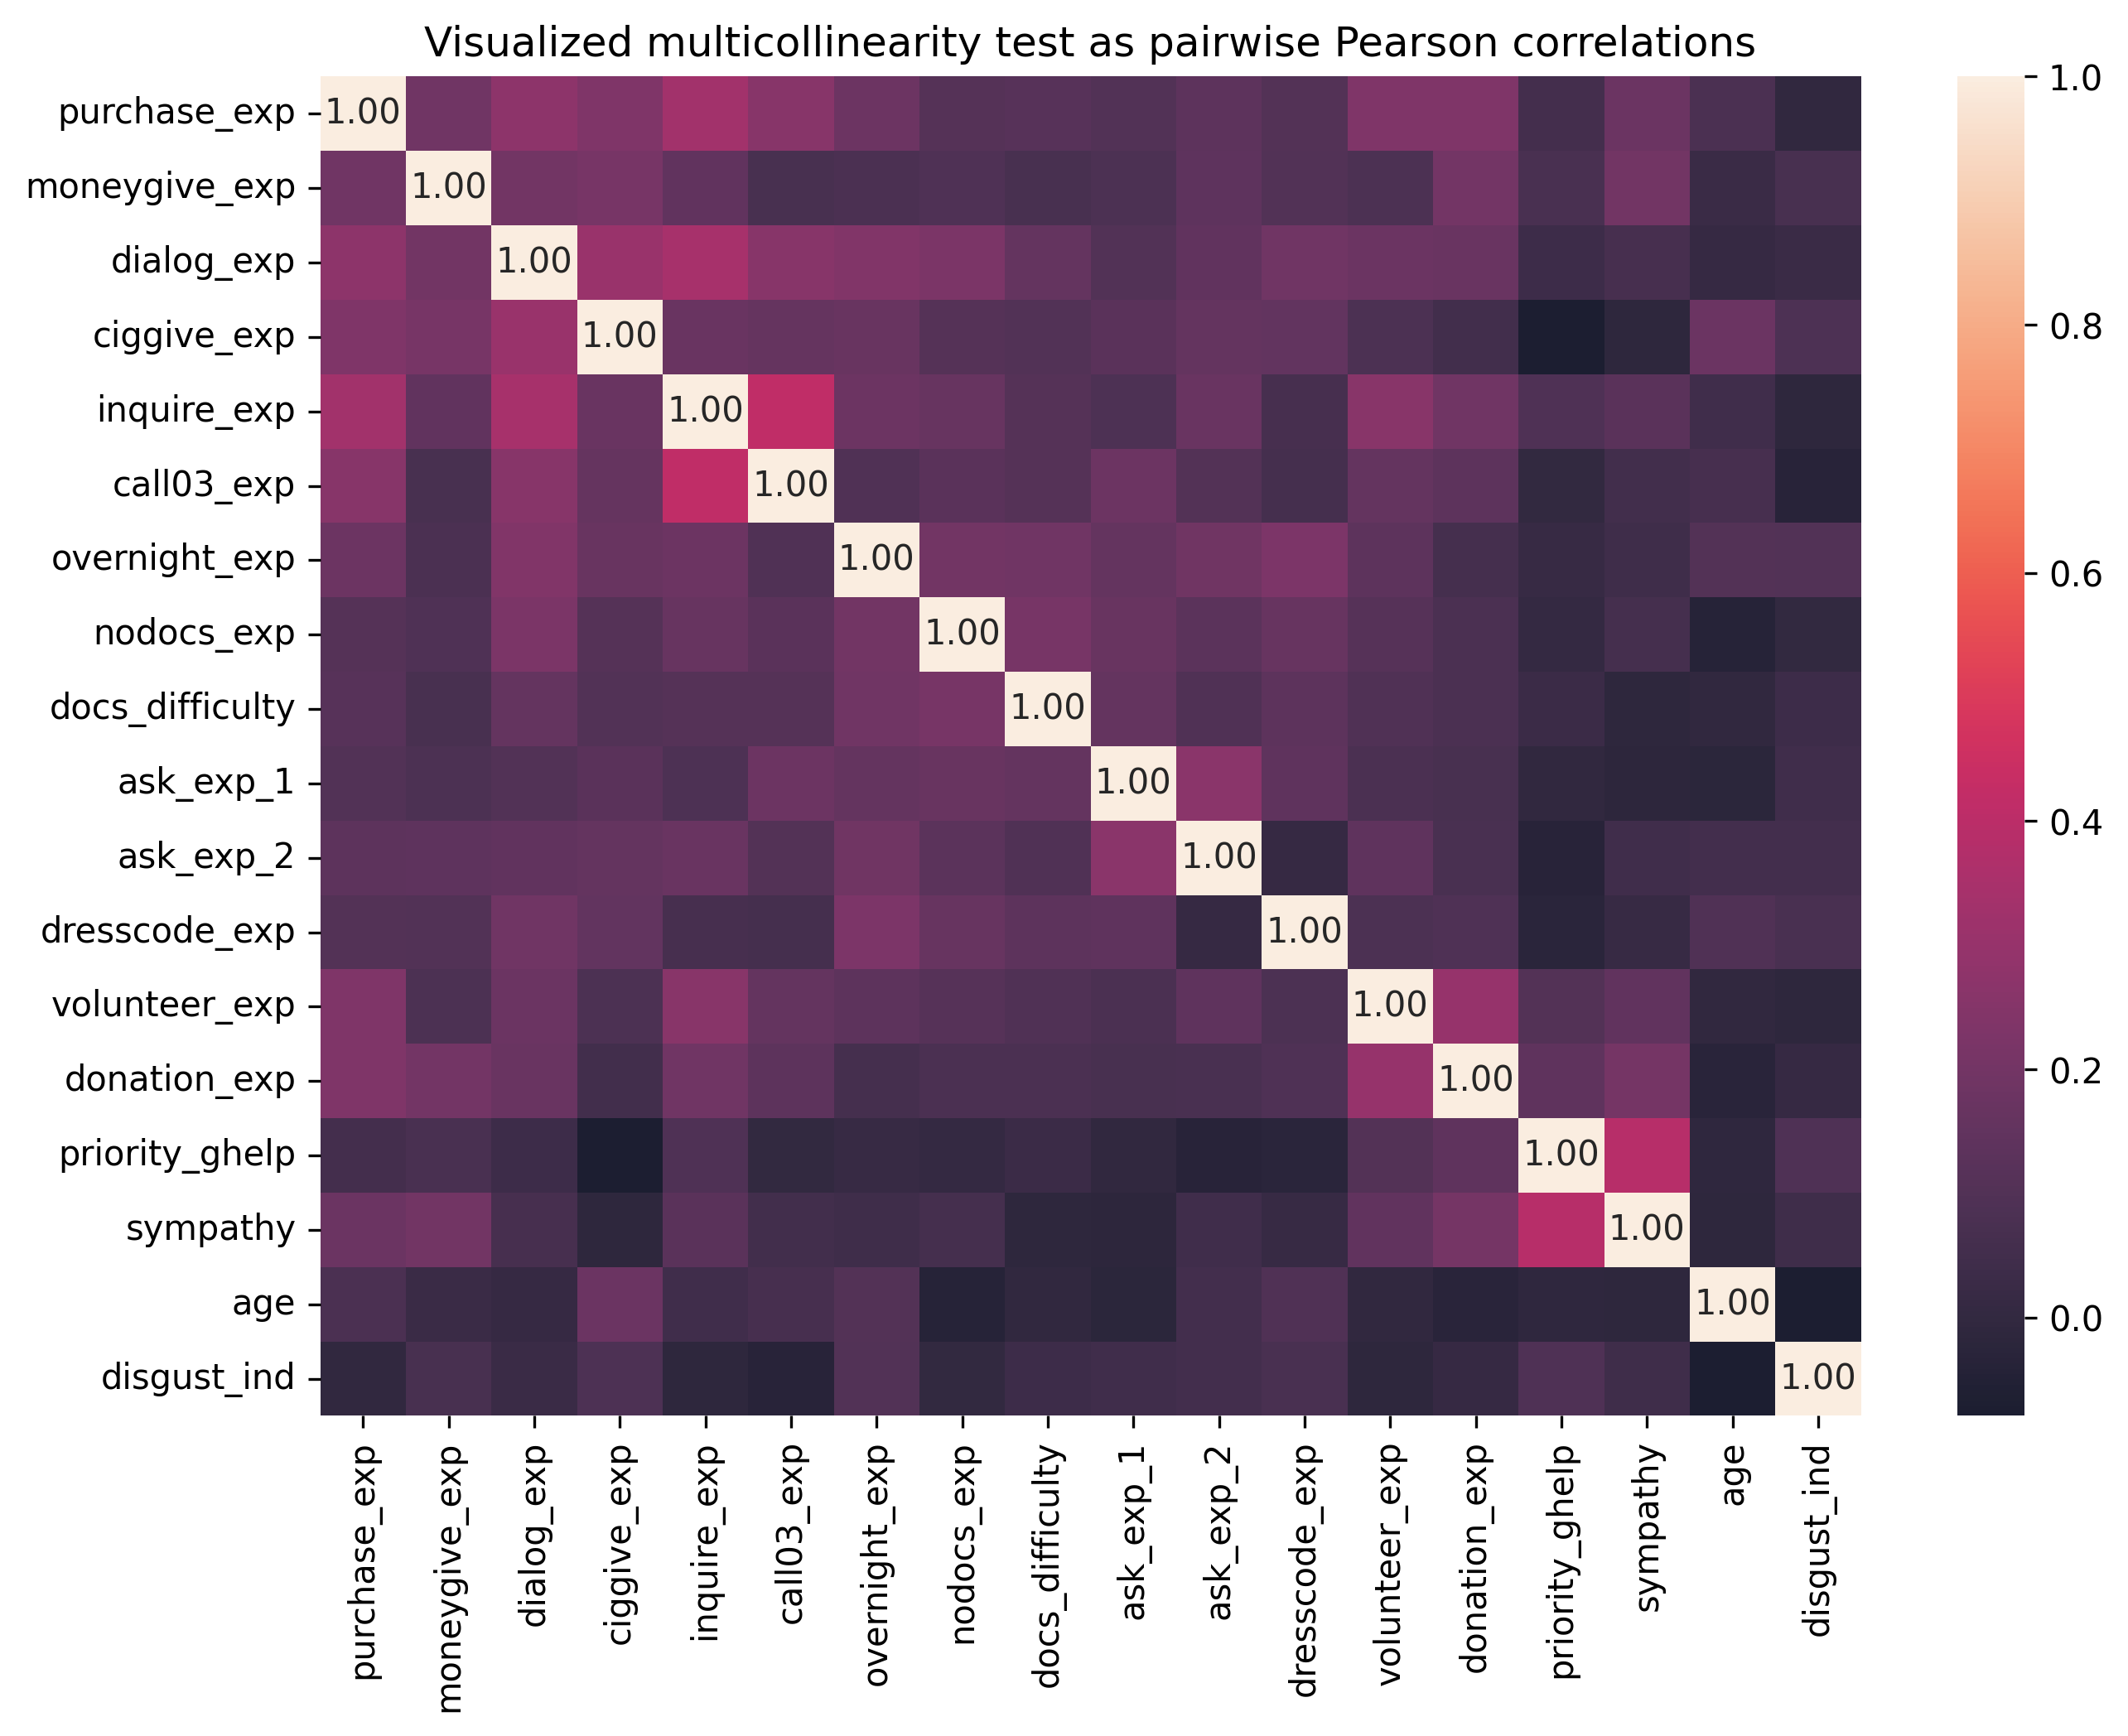

In [72]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7), dpi=300)
ax = sns.heatmap(X.corr(numeric_only=True), annot=True, cmap='rocket', fmt="0.2f", alpha=0.9)

for i in ax.texts:
    if abs(float(i.get_text())) < 0.5:
        i.set_text('')
        
ax.set_title('Visualized multicollinearity test as pairwise Pearson correlations')
plt.show()

In [73]:
condition_number = np.linalg.cond(X.select_dtypes(include='number'))
print(condition_number)

74.46199927199912


##### Константная модель

In [74]:
y_pred = [y['attitude'].mean()] * X.shape[0]
print("RMSE:", root_mean_squared_error(y['attitude'], y_pred))
print("MAE:", mean_absolute_error(y['attitude'], y_pred))
print("R2 score on whole data:", r2_score(y['attitude'], y_pred))

RMSE: 0.32583148841919557
MAE: 0.2571921477437036
R2 score on whole data: 0.0


#### Models with manifest variables

##### Default Linear Regression

In [75]:
regressor = LinearRegression()

regressor.fit(X_ohe_train, y_ohe_train['attitude'])

print("RMSE on train:", root_mean_squared_error(y_ohe_train['attitude'], regressor.predict(X_ohe_train)))
print("MAE on train:", mean_absolute_error(y_ohe_train['attitude'], regressor.predict(X_ohe_train)))
print("RMSE on test:", root_mean_squared_error(y_ohe_test['attitude'], regressor.predict(X_ohe_test)))
print("MAE on test:", mean_absolute_error(y_ohe_test['attitude'], regressor.predict(X_ohe_test)))      
print("R2 score on whole data:", r2_score(y['attitude'], regressor.predict(X_ohe)))

RMSE on train: 0.21452577424890362
MAE on train: 0.1682137572268235
RMSE on test: 0.2410045561782699
MAE on test: 0.1926036948521484
R2 score on whole data: 0.5380300852492843


<Axes: ylabel='attitude'>

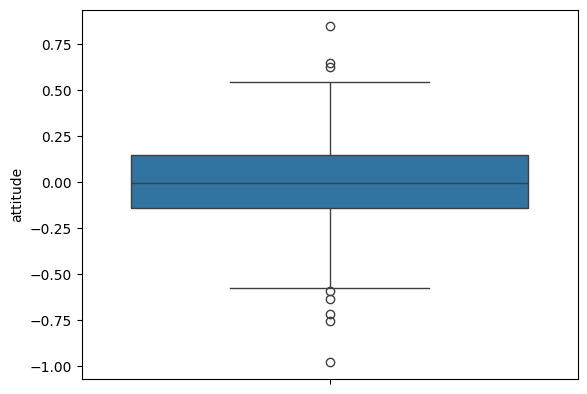

In [76]:
pred_diff = y['attitude'] - regressor.predict(X_ohe)
sns.boxplot(pred_diff)

<Axes: xlabel='attitude'>

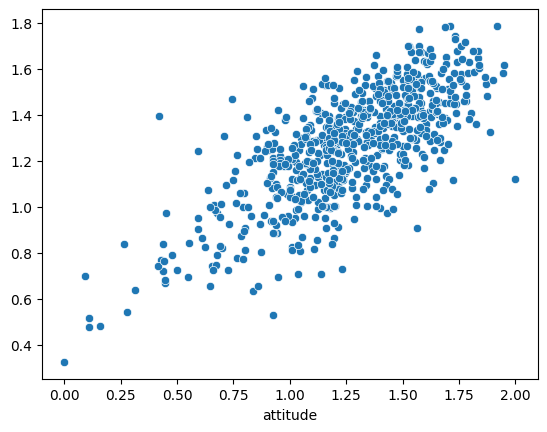

In [78]:
regressor.fit(X_ohe, y['attitude'])

sns.scatterplot(x=y['attitude'], y=regressor.predict(X_ohe))

##### L1-Regularization

In [79]:
regressor = LassoCV(random_state=42)

regressor.fit(X_ohe_train, y_ohe_train['attitude'])

print("RMSE on train:", root_mean_squared_error(y_ohe_train['attitude'], regressor.predict(X_ohe_train)))
print("MAE on train:", mean_absolute_error(y_ohe_train['attitude'], regressor.predict(X_ohe_train)))
print("RMSE on test:", root_mean_squared_error(y_ohe_test['attitude'], regressor.predict(X_ohe_test)))
print("MAE on test:", mean_absolute_error(y_ohe_test['attitude'], regressor.predict(X_ohe_test)))      
print("R2 score on whole data:", r2_score(y['attitude'], regressor.predict(X_ohe)))

RMSE on train: 0.2192808547009341
MAE on train: 0.17067079205954025
RMSE on test: 0.2401844634087159
MAE on test: 0.19152581140222472
R2 score on whole data: 0.5244038689370738


##### L2-Regularization

In [80]:
regressor = RidgeCV()

regressor.fit(X_ohe_train, y_ohe_train['attitude'])

print("RMSE on train:", root_mean_squared_error(y_ohe_train['attitude'], regressor.predict(X_ohe_train)))
print("MAE on train:", mean_absolute_error(y_ohe_train['attitude'], regressor.predict(X_ohe_train)))
print("RMSE on test:", root_mean_squared_error(y_ohe_test['attitude'], regressor.predict(X_ohe_test)))
print("MAE on test:", mean_absolute_error(y_ohe_test['attitude'], regressor.predict(X_ohe_test)))      
print("R2 score on whole data:", r2_score(y['attitude'], regressor.predict(X_ohe)))

RMSE on train: 0.21490937432300172
MAE on train: 0.16834801337571145
RMSE on test: 0.23989255463397946
MAE on test: 0.1916619317867958
R2 score on whole data: 0.5381304081639036


Можно утверждать, что Lasso и Ridge дают примерно одинаковые результаты по всем метрикам

##### Bagging

In [81]:
params = {
    'n_estimators': [10, 50, 100, 200],
    'max_samples': [0.5, 0.7, 0.9],
    'max_features': [0.5, 0.7, 0.9]
    }

gs = GridSearchCV(BaggingRegressor(random_state=42, n_jobs=-1), param_grid=params)

gs.fit(X_ohe_train, y_ohe_train["attitude"])

best_params = gs.best_params_
best_params

{'max_features': 0.9, 'max_samples': 0.7, 'n_estimators': 200}

In [82]:
regressor = BaggingRegressor(n_estimators=200, 
                             max_features=0.9, 
                             max_samples=0.7, 
                             random_state=42)

regressor.fit(X_ohe_train, y_ohe_train["attitude"])

print("RMSE on train:", root_mean_squared_error(y_ohe_train['attitude'], regressor.predict(X_ohe_train)))
print("MAE on train:", mean_absolute_error(y_ohe_train['attitude'], regressor.predict(X_ohe_train)))
print("RMSE on test:", root_mean_squared_error(y_ohe_test['attitude'], regressor.predict(X_ohe_test)))
print("MAE on test:", mean_absolute_error(y_ohe_test['attitude'], regressor.predict(X_ohe_test)))      
print("R2 score on whole data:", r2_score(indexes['attitude'], regressor.predict(X_ohe)))

RMSE on train: 0.11447551447606125
MAE on train: 0.08990338698266719
RMSE on test: 0.24563279396341725
MAE on test: 0.19126526896875734
R2 score on whole data: 0.7650214060665828


##### Random Forest

In [83]:
params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'max_samples': [0.5, 0.7, 0.9],
    'max_features': [0.5, 0.7, 0.9]
}

gs = GridSearchCV(RandomForestRegressor(random_state=42, n_jobs=-1), param_grid=params)

gs.fit(X_ohe_train, y_ohe_train["attitude"])

best_params = gs.best_params_
best_params

{'max_depth': 10,
 'max_features': 0.9,
 'max_samples': 0.7,
 'min_samples_split': 5,
 'n_estimators': 100}

In [84]:
regressor = RandomForestRegressor(n_estimators=100, 
                                  max_features=0.9, 
                                  max_samples=0.7, 
                                  max_depth=10,
                                  min_samples_split=5,
                                  random_state=42)

regressor.fit(X_ohe_train, y_ohe_train["attitude"])

print("RMSE on train:", root_mean_squared_error(y_ohe_train['attitude'], regressor.predict(X_ohe_train)))
print("MAE on train:", mean_absolute_error(y_ohe_train['attitude'], regressor.predict(X_ohe_train)))
print("RMSE on test:", root_mean_squared_error(y_ohe_test['attitude'], regressor.predict(X_ohe_test)))
print("MAE on test:", mean_absolute_error(y_ohe_test['attitude'], regressor.predict(X_ohe_test)))      
print("R2 score on whole data:", r2_score(y['attitude'], regressor.predict(X_ohe)))

RMSE on train: 0.13880671274671197
MAE on train: 0.10810785854952533
RMSE on test: 0.24583859147986567
MAE on test: 0.19326934125125758
R2 score on whole data: 0.7212893637668156


##### Gradient Boosting

In [85]:
pool = Pool(X_train, y_train['attitude'], cat_features=['purchase_exp', 'moneygive_exp', 'dialog_exp', 
                                'ciggive_exp', 'inquire_exp', 'call03_exp','overnight_exp', 'nodocs_exp',
                                'docs_difficulty', 'ask_exp_1', 'ask_exp_2', 'dresscode_exp',
                                'volunteer_exp', 'donation_exp', 'known_org', 'media_freq', 'gndr', 
                                'major', 'housing', 'age', 'fin_sit'])

regressor = CatBoostRegressor(silent=True,
                              allow_writing_files=False, 
                              random_seed=42, 
                              depth=10, 
                              n_estimators=200, 
                              learning_rate=0.3,
                              min_child_samples=5,
                              early_stopping_rounds=50)
regressor.fit(pool)

print("RMSE on train:", root_mean_squared_error(y_train['attitude'], regressor.predict(X_train[regressor.feature_names_])))
print("MAE on train:", mean_absolute_error(y_train['attitude'], regressor.predict(X_train[regressor.feature_names_])))
print("RMSE on test:", root_mean_squared_error(y_test['attitude'], regressor.predict(X_test[regressor.feature_names_])))
print("MAE on test:", mean_absolute_error(y_test['attitude'], regressor.predict(X_test[regressor.feature_names_])))      
print("R2 score on whole data:", r2_score(y['attitude'], regressor.predict(X[regressor.feature_names_])))

RMSE on train: 0.11452954949521177
MAE on train: 0.0826975575840382
RMSE on test: 0.20992621633544925
MAE on test: 0.16907240094092332
R2 score on whole data: 0.8471239276582689


### Regressions without manifest variables

In [86]:
X_latent = X.drop(columns=['priority_ghelp', 'sympathy'])

In [87]:
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

X_ohe = ohe.fit_transform(X[['known_org', 'media_freq', 'gndr', 'major', 'housing', 'fin_sit']])
X_ohe = pd.DataFrame(X_ohe, columns=ohe.get_feature_names_out())
X_ohe = pd.concat([X_latent.drop(columns=['known_org', 'media_freq', 'gndr', 
                                          'major', 'housing', 'fin_sit']), X_ohe], axis=1)

X_ohe_train, X_ohe_test, y_ohe_train, y_ohe_test = train_test_split(X_ohe, y)

##### Model pretests

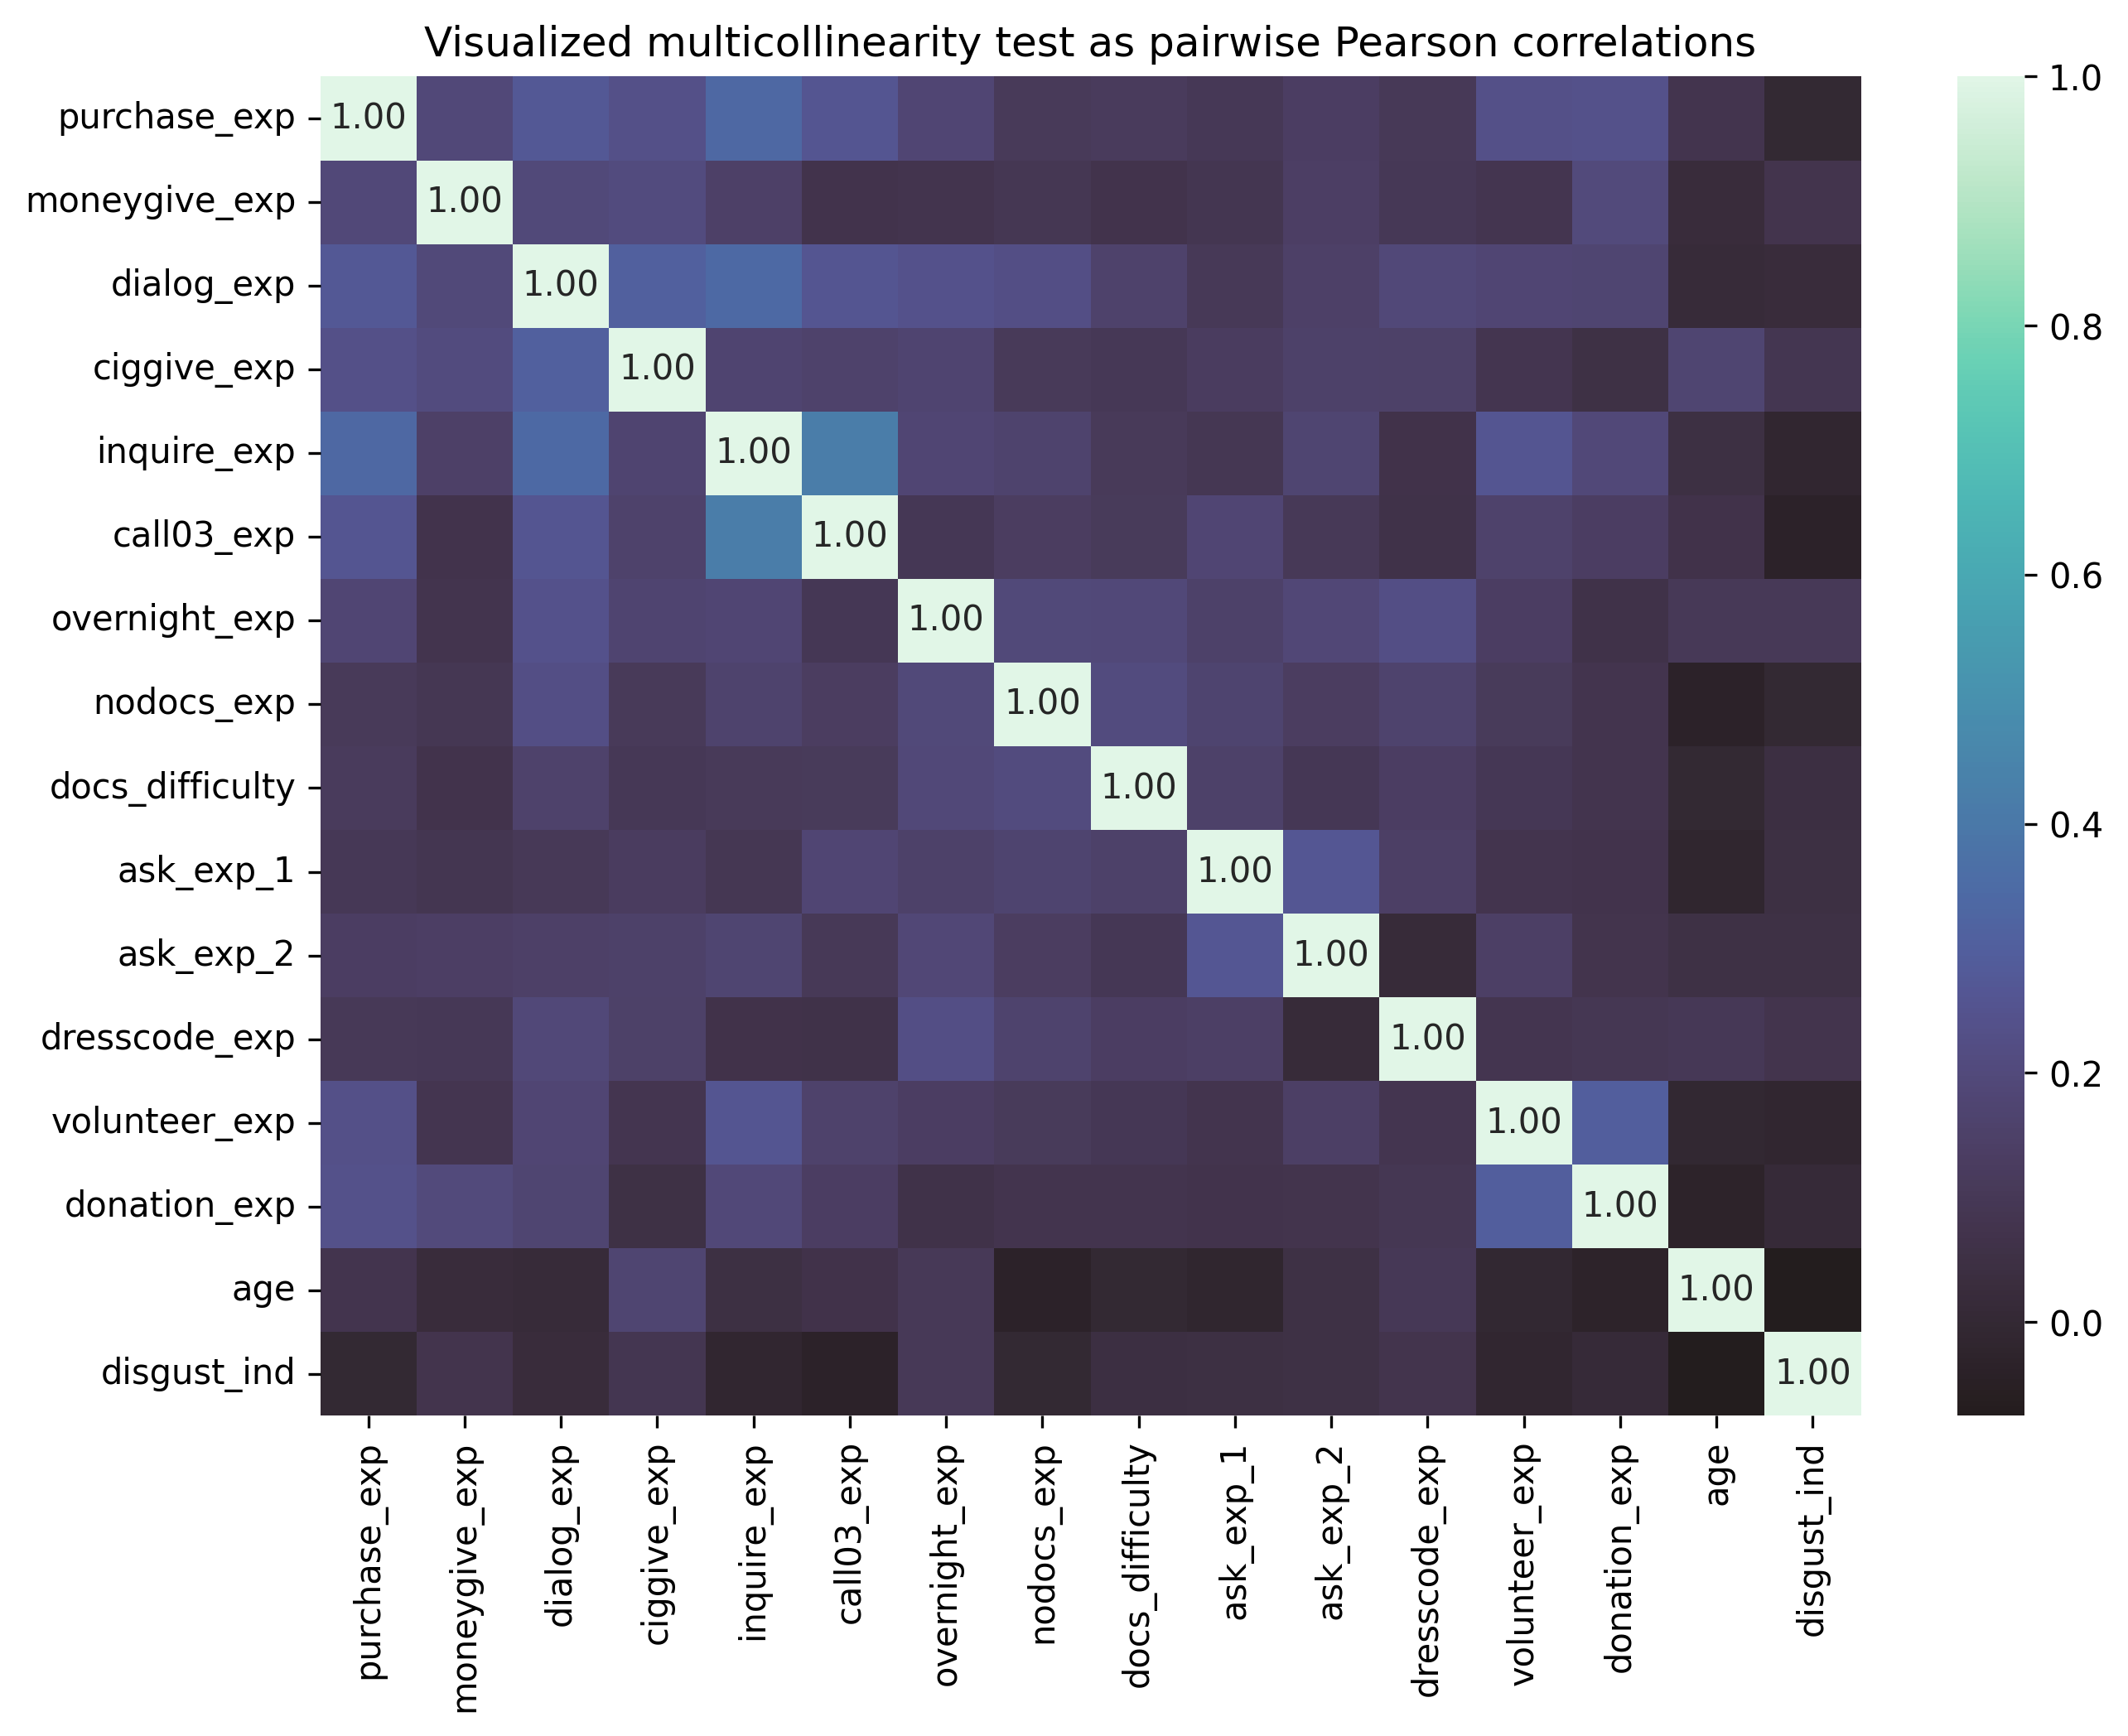

In [88]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7), dpi=300)
ax = sns.heatmap(X_latent.corr(numeric_only=True), annot=True, cmap='mako', fmt="0.2f", alpha=0.9)

for i in ax.texts:
    if abs(float(i.get_text())) < 0.5:
        i.set_text('')
        
ax.set_title('Visualized multicollinearity test as pairwise Pearson correlations')
plt.show()

##### Default Linear Regression

In [89]:
regressor = LinearRegression()

regressor.fit(X_ohe_train, y_ohe_train['attitude'])

print("RMSE on train:", root_mean_squared_error(y_ohe_train['attitude'], regressor.predict(X_ohe_train)))
print("MAE on train:", mean_absolute_error(y_ohe_train['attitude'], regressor.predict(X_ohe_train)))
print("RMSE on test:", root_mean_squared_error(y_ohe_test['attitude'], regressor.predict(X_ohe_test)))
print("MAE on test:", mean_absolute_error(y_ohe_test['attitude'], regressor.predict(X_ohe_test)))      
print("R2 score on whole data:", r2_score(y['attitude'], regressor.predict(X_ohe)))

RMSE on train: 0.2680727024928844
MAE on train: 0.2098112321474387
RMSE on test: 0.3203488515001415
MAE on test: 0.2382257819763786
R2 score on whole data: 0.2504627039315479


<Axes: ylabel='attitude'>

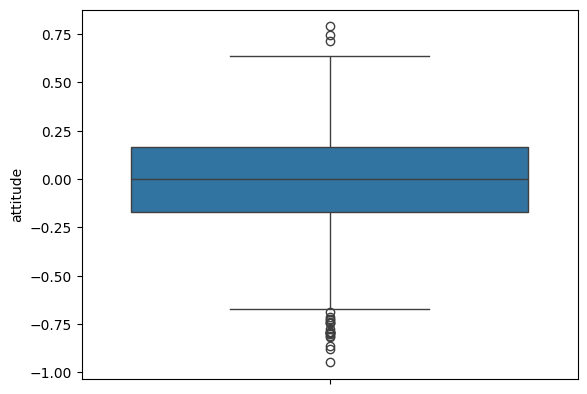

In [90]:
pred_diff = y['attitude'] - regressor.predict(X_ohe)
sns.boxplot(pred_diff)

In [91]:
q1 = np.percentile(pred_diff, 25)
q3 = np.percentile(pred_diff, 75)
iqr = q3 - q1

outliers = [x for x in pred_diff if (x < q1 - 1.5 * iqr) or (x > q3 + 1.5 * iqr)]
len(outliers)

22

<Axes: xlabel='attitude'>

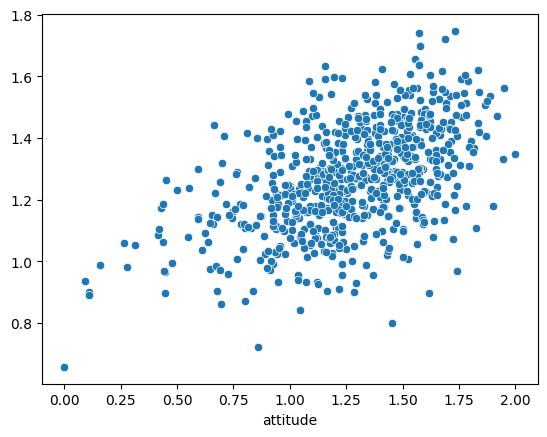

In [92]:
regressor.fit(X_ohe, y['attitude'])

sns.scatterplot(x=y['attitude'], y=regressor.predict(X_ohe))

##### L1-Regularization

In [93]:
regressor = LassoCV(random_state=42)

regressor.fit(X_ohe_train, y_ohe_train['attitude'])

print("RMSE on train:", root_mean_squared_error(y_ohe_train['attitude'], regressor.predict(X_ohe_train)))
print("MAE on train:", mean_absolute_error(y_ohe_train['attitude'], regressor.predict(X_ohe_train)))
print("RMSE on test:", root_mean_squared_error(y_ohe_test['attitude'], regressor.predict(X_ohe_test)))
print("MAE on test:", mean_absolute_error(y_ohe_test['attitude'], regressor.predict(X_ohe_test)))      
print("R2 score on whole data:", r2_score(y['attitude'], regressor.predict(X_ohe)))

RMSE on train: 0.2708116215509504
MAE on train: 0.21252610451630227
RMSE on test: 0.31646103648278534
MAE on test: 0.23314375669415244
R2 score on whole data: 0.24589305684977358


##### L2-Regularization

In [94]:
regressor = RidgeCV()

regressor.fit(X_ohe_train, y_ohe_train['attitude'])

print("RMSE on train:", root_mean_squared_error(y_ohe_train['attitude'], regressor.predict(X_ohe_train)))
print("MAE on train:", mean_absolute_error(y_ohe_train['attitude'], regressor.predict(X_ohe_train)))
print("RMSE on test:", root_mean_squared_error(y_ohe_test['attitude'], regressor.predict(X_ohe_test)))
print("MAE on test:", mean_absolute_error(y_ohe_test['attitude'], regressor.predict(X_ohe_test)))      
print("R2 score on whole data:", r2_score(indexes['attitude'], regressor.predict(X_ohe)))

RMSE on train: 0.26860170290690416
MAE on train: 0.21025233040043503
RMSE on test: 0.3182445847655426
MAE on test: 0.2354748406050214
R2 score on whole data: 0.25163258540465916


##### Bagging

In [95]:
params = {
    'n_estimators': [10, 50, 100, 200],
    'max_samples': [0.5, 0.7, 0.9],
    'max_features': [0.5, 0.7, 0.9]
    }

gs = GridSearchCV(BaggingRegressor(random_state=42, n_jobs=-1), param_grid=params)

gs.fit(X_ohe_train, y_ohe_train["attitude"])

best_params = gs.best_params_
best_params

{'max_features': 0.9, 'max_samples': 0.7, 'n_estimators': 200}

In [96]:
regressor = BaggingRegressor(n_estimators=200, 
                             max_features=0.9, 
                             max_samples=0.7)

regressor.fit(X_ohe_train, y_ohe_train["attitude"])

print("RMSE on train:", root_mean_squared_error(y_ohe_train['attitude'], regressor.predict(X_ohe_train)))
print("MAE on train:", mean_absolute_error(y_ohe_train['attitude'], regressor.predict(X_ohe_train)))
print("RMSE on test:", root_mean_squared_error(y_ohe_test['attitude'], regressor.predict(X_ohe_test)))
print("MAE on test:", mean_absolute_error(y_ohe_test['attitude'], regressor.predict(X_ohe_test)))      
print("R2 score on whole data:", r2_score(y['attitude'], regressor.predict(X_ohe)))

RMSE on train: 0.14366624971391373
MAE on train: 0.11310146577644155
RMSE on test: 0.32178568548450753
MAE on test: 0.23282149254169607
R2 score on whole data: 0.6097915953978744


##### Random Forest

In [97]:
params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'max_samples': [0.5, 0.7, 0.9],
    'max_features': [0.5, 0.7, 0.9]
}

gs = GridSearchCV(RandomForestRegressor(random_state=42, n_jobs=-1), param_grid=params)

gs.fit(X_ohe_train, y_ohe_train["attitude"])

best_params = gs.best_params_
best_params

{'max_depth': 20,
 'max_features': 0.7,
 'max_samples': 0.5,
 'min_samples_split': 2,
 'n_estimators': 200}

In [98]:
regressor = RandomForestRegressor(n_estimators=200,
                                  max_depth=20, 
                                  min_samples_split=2, 
                                  max_features=0.5, 
                                  max_samples=0.7,
                                  random_state=42)

regressor.fit(X_ohe_train, y_ohe_train["attitude"])

print("RMSE on train:", root_mean_squared_error(y_ohe_train['attitude'], regressor.predict(X_ohe_train)))
print("MAE on train:", mean_absolute_error(y_ohe_train['attitude'], regressor.predict(X_ohe_train)))
print("RMSE on test:", root_mean_squared_error(y_ohe_test['attitude'], regressor.predict(X_ohe_test)))
print("MAE on test:", mean_absolute_error(y_ohe_test['attitude'], regressor.predict(X_ohe_test)))      
print("R2 score on whole data:", r2_score(indexes['attitude'], regressor.predict(X_ohe)))

RMSE on train: 0.143338327638444
MAE on train: 0.1122392259752426
RMSE on test: 0.3271379344481764
MAE on test: 0.23591983127230232
R2 score on whole data: 0.6022532806114097


##### Gradient Boosting

In [19]:
X_latent = X.drop(columns=['priority_ghelp', 'sympathy'])
X_train, X_test, y_train, y_test = train_test_split(X_latent, y, test_size=0.1)

pool = Pool(X_train, y_train['attitude'], cat_features=['purchase_exp', 'moneygive_exp', 'dialog_exp', 
                                'ciggive_exp', 'inquire_exp', 'call03_exp','overnight_exp', 'nodocs_exp',
                                'docs_difficulty', 'ask_exp_1', 'ask_exp_2', 'dresscode_exp',
                                'volunteer_exp', 'donation_exp', 'known_org', 'media_freq', 'gndr', 
                                'major', 'housing', 'age', 'fin_sit'])

regressor = CatBoostRegressor(silent=True,
                              allow_writing_files=True, 
                              random_seed=42, 
                              depth=10, 
                              n_estimators=200, 
                              learning_rate=0.4,
                              min_child_samples=5,
                              early_stopping_rounds=50)
regressor.fit(pool)

In [20]:
mv = MetricVisualizer('catboost_info/')
mv.start()

print("RMSE on train:", root_mean_squared_error(y_train['attitude'], regressor.predict(X_train[regressor.feature_names_])))
print("MAE on train:", mean_absolute_error(y_train['attitude'], regressor.predict(X_train[regressor.feature_names_])))
print("RMSE on test:", root_mean_squared_error(y_test['attitude'], regressor.predict(X_test[regressor.feature_names_])))
print("MAE on test:", mean_absolute_error(y_test['attitude'], regressor.predict(X_test[regressor.feature_names_])))      
print("R2 score on whole data:", r2_score(indexes['attitude'], regressor.predict(X_latent[regressor.feature_names_])))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

RMSE on train: 0.176120700946434
MAE on train: 0.12295267194292417
RMSE on test: 0.2626643892395021
MAE on test: 0.21128953504575004
R2 score on whole data: 0.6718535170836869


# Cluster Analysis

In [107]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(X_ohe)
data_scaled = pd.DataFrame(data_scaled, columns=scaler.get_feature_names_out())

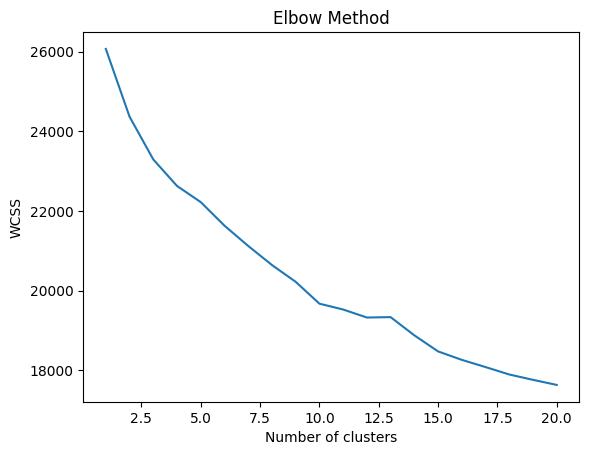

In [108]:
wcss = []
for k in range(1, 21):
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    kmeans.fit(data_scaled)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 21), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

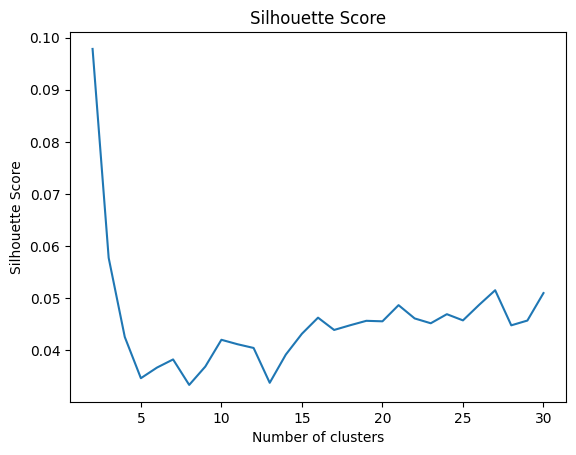

In [109]:
silhouette_scores = []
for k in range(2, 31):
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    cluster_labels = kmeans.fit_predict(data_scaled)
    silhouette_avg = silhouette_score(data_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)


plt.plot(range(2, 31), silhouette_scores)
plt.title('Silhouette Score')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()

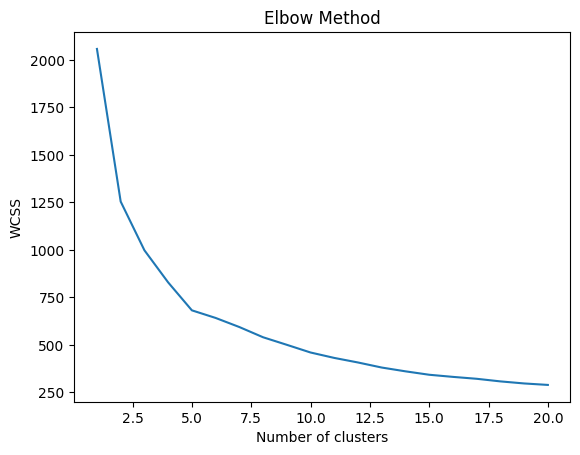

In [25]:
scaler = StandardScaler()
ind_scaled = scaler.fit_transform(data[['policy_ind', 'public_att_ind', 'disgust_ind']])
ind_scaled = pd.DataFrame(ind_scaled, columns=scaler.get_feature_names_out())
wcss = []
for k in range(1, 21):
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    kmeans.fit(ind_scaled)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 21), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

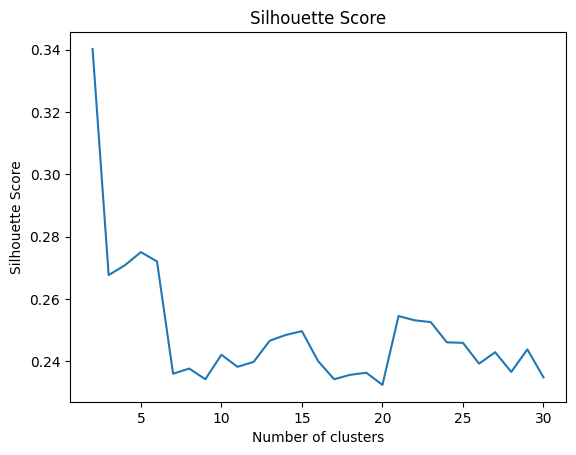

In [26]:
silhouette_scores = []
for k in range(2, 31):
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    cluster_labels = kmeans.fit_predict(ind_scaled)
    silhouette_avg = silhouette_score(ind_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)


plt.plot(range(2, 31), silhouette_scores)
plt.title('Silhouette Score')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()

In [35]:
model = KMeans(n_clusters=5, init='k-means++', random_state=42)
preds = model.fit_predict(ind_scaled)
cl = pd.concat([data[['policy_ind', 'public_att_ind', 'disgust_ind']], pd.Series(preds, name='Cluster')], axis=1)
for i in range(4):
    print(cl[cl['Cluster'] == i].sample())

     policy_ind  public_att_ind  disgust_ind  Cluster
594    0.772727        0.527778           19        0
     policy_ind  public_att_ind  disgust_ind  Cluster
408    0.704545        0.722222            3        1
     policy_ind  public_att_ind  disgust_ind  Cluster
236    0.681818        0.472222           -6        2
    policy_ind  public_att_ind  disgust_ind  Cluster
42    0.522727        0.138889           -5        3
